In [710]:
# Loading the libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [711]:
# Rutas
DATA_DIR = Path(r"C:\Users\chile\projects\proy_insurance\data\clean_data")
CSV_IN   = DATA_DIR / "coil2000_clean.csv"
PLOTS_DIR = DATA_DIR / "eda_plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

CAT_COLS = ["MOSTYPE", "MOSHOOFD", "MKOOPKLA"]

In [712]:
# Inmportamos el csv
df_clean = pd.read_csv(DATA_DIR / "coil2000_clean.csv")

print("Shape:", df.shape)
print("Columnas:", df.columns[:])
# Para fines de identificar outliers vamos a eliminar las variables categoricas que 
# que previamente ya fueron limpiadas

df_sin_cat = df_clean.drop(columns=CAT_COLS, errors="ignore")

Shape: (626, 86)
Columnas: Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
       'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',
 

In [713]:
# Cuantos clientes de cada clase tenemos
(df_clean["CARAVAN"].value_counts(normalize=True) * 100).round(2)

CARAVAN
0    92.81
1     7.19
Name: proportion, dtype: float64

In [714]:
#Anlizando los valores extremos de cada variable

print(round(df_sin_cat.describe(),2))    # numéricas

       MAANTHUI  MGEMOMV  MGEMLEEF  MGODRK  MGODPR  MGODOV  MGODGE  MRELGE  \
count    626.00   626.00    626.00  626.00  626.00  626.00  626.00  626.00   
mean       1.13     2.60      3.00    0.74    8.96    3.51    4.71   11.19   
std        0.37     0.81      0.88    1.00   52.00   37.86   34.20   54.44   
min        1.00     1.00      1.00    0.00    0.00    0.00    0.00    0.00   
25%        1.00     2.00      2.00    0.00    4.00    0.00    2.00    5.00   
50%        1.00     3.00      3.00    0.00    5.00    1.00    3.00    6.00   
75%        1.00     3.00      3.00    1.00    5.00    2.00    4.00    7.00   
max        3.00     5.00      6.00    7.00  949.00  751.00  858.00  887.00   

       MRELSA  MRELOV  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  \
count  626.00  626.00  ...    626.00   626.00   626.00  626.00   626.00   
mean     4.45    6.31  ...      0.97     2.81     1.86    2.84     1.67   
std     38.11   49.27  ...     14.60    41.81    38.58   28.05    28.53 

In [715]:
# Función para definir los límites y determinar outliers

def detect_outliers_iqr(df, cols=None, k=1.5, exclude=None):
    """Devuelve (bounds, outliers_long, counts) por IQR."""
    exclude = exclude or []
    cols = cols or df.select_dtypes(include="number").columns.difference(exclude).tolist()

    q1, q3 = df[cols].quantile(0.25), df[cols].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    
    with np.errstate(divide="ignore", invalid="ignore"):
        extrem_max = round(df[cols].max() / q3.replace(0, np.nan),2)
        extrem_min = round(df[cols].min() / q1.replace(0, np.nan),2)

    bounds = pd.DataFrame({"Q1": q1, "Q3": q3, "IQR": iqr, 
                           "lower": lower, "upper": upper,
                           "extrem_min": extrem_min,"extrem_max": extrem_max})
    
    print(bounds.columns)

    parts = []
    for c in cols:
        s = df[c]
        m = (s < lower[c]) | (s > upper[c])
        if m.any():
            parts.append(pd.DataFrame({
                "index": s.index[m],
                "col": c,
                "value": s[m].values,
                "lower": lower[c],
                "upper": upper[c],
                "extrem_min": extrem_min[c],
                "extrem_max": extrem_max[c],
            }))
            
    outliers_long = (pd.concat(parts, ignore_index=True)
                     if parts else pd.DataFrame(columns=["index","col","value","lower","upper","extrem_min","extrem_max"]))
    counts = outliers_long["col"].value_counts().rename("n_outliers").sort_values(ascending=False)
    return bounds, outliers_long, counts


In [716]:
# Muestra las variables que tiene más outliers
umbrales, outliers, cuenta_out = detect_outliers_iqr(df_sin_cat, cols=None, k=1.5, exclude=None)
umbrales_no_nan = umbrales[umbrales["extrem_max"].notna()].copy()
print(umbrales_no_nan)

Index(['Q1', 'Q3', 'IQR', 'lower', 'upper', 'extrem_min', 'extrem_max'], dtype='object')
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MAANTHUI  1.0  1.0  0.0    1.0    1.0         1.0        3.00
MGEMOMV   2.0  3.0  1.0    0.5    4.5         0.5        1.67
MGEMLEEF  2.0  3.0  1.0    0.5    4.5         0.5        2.00
MGODRK    0.0  1.0  1.0   -1.5    2.5         NaN        7.00
MGODPR    4.0  5.0  1.0    2.5    6.5         0.0      189.80
MGODOV    0.0  2.0  2.0   -3.0    5.0         NaN      375.50
MGODGE    2.0  4.0  2.0   -1.0    7.0         0.0      214.50
MRELGE    5.0  7.0  2.0    2.0   10.0         0.0      126.71
MRELSA    0.0  2.0  2.0   -3.0    5.0         NaN      334.00
MRELOV    1.0  3.0  2.0   -2.0    6.0         0.0      303.67
MFALLEEN  0.0  3.0  3.0   -4.5    7.5         NaN      292.67
MFGEKIND  2.0  4.0  2.0   -1.0    7.0         0.0      228.00
MFWEKIND  3.0  6.0  3.0   -1.5   10.5         0.0      119.83
MOPLHOOG  0.0  2.0  2.0   -3.0    5.0      

In [717]:
# Vamos a determinar las variables donde NO vamos a eliminar los outlier
print(round(umbrales_no_nan['extrem_max'].describe(),2))

#umbrales_no_nan.extrem_max.plot(kind = "hist",bins=100)

p_select = round(umbrales_no_nan["extrem_max"].quantile(0.15),2)
print('Valor de percentil 15% = ',p_select,'\n')
#umbrales_no_nan.loc[umbrales_no_nan["extrem_max"] <= p_select, "extrem_max"].plot(kind="hist", bins=100)

v_no_delet_out = umbrales_no_nan.loc[umbrales_no_nan["extrem_max"] <= p_select]
v_lista_mantener= (
    umbrales_no_nan
      .loc[umbrales_no_nan["extrem_max"] <= p_select]
      .index
      .tolist()
)

print(f'Variables a las que NO se les eliminaran los outliers \n',v_no_delet_out, '\n')
print(f'Variables a las que NO se les eliminaran los outliers \n',v_lista_mantener, '\n')


count       45.00
mean       895.17
std       4251.02
min          1.50
25%         98.00
50%        189.80
75%        303.67
max      28719.50
Name: extrem_max, dtype: float64
Valor de percentil 15% =  75.2 

Variables a las que NO se les eliminaran los outliers 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MAANTHUI  1.0  1.0  0.0    1.0    1.0         1.0        3.00
MGEMOMV   2.0  3.0  1.0    0.5    4.5         0.5        1.67
MGEMLEEF  2.0  3.0  1.0    0.5    4.5         0.5        2.00
MGODRK    0.0  1.0  1.0   -1.5    2.5         NaN        7.00
MSKA      0.0  2.0  2.0   -3.0    5.0         NaN       68.00
PWAPART   2.0  2.0  0.0    2.0    2.0         0.5        1.50
AWAPART   1.0  1.0  0.0    1.0    1.0         1.0       10.00 

Variables a las que NO se les eliminaran los outliers 
 ['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MSKA', 'PWAPART', 'AWAPART'] 



In [743]:
# Para explorar una variable como se vería sin outliers
def outlier_var(y_var, df, outliers_long = outliers, bounds = umbrales):
    # y_var puede ser string o lista/tupla
    cols = [y_var] if isinstance(y_var, str) else list(y_var)

    print(f' ---> Límites Outliers {y_var} \n',bounds.loc[[y_var]],'\n')

    if outliers_long is None or outliers_long.empty:
        return df.copy()

    # índices de filas con outliers en esas columnas
    idx = outliers_long.loc[outliers_long['col'].isin(cols), 'index'].unique()

    # devuelve df sin esas filas
    return df.drop(index=idx, errors="ignore").reset_index(drop=True)

In [747]:
# Función para graficar información de una varaible en particular
'Hay que declara la variable Objetivo y la covariable y'
'Además declarar las dimensiones del grid filas x columnas'

def info_variable(x_target, y_var, tabla, filas, columnas):
    
    df_fnc = outlier_var(y_var, tabla, outliers_long = outliers, bounds = umbrales)

    #print(f' ---> Tendecia central {y_var} \n',round(tabla[y_var].describe(),2),'\n')
    #print(f' ---> Tendecia central {y_var} sin outliers \n',round(df_fnc[y_var].describe(),2),'\n')

    # estadísticos que quieres
    #stats = ["count", "mean", "median", "std"]

    # calcular por clase 0 y 1 y unir
    tabla_ct = (
    df_fnc.groupby(x_target)[y_var]
          .agg(count="count", mean="mean", median="median", std="std", min='min', max='max')
          .round(2)
          .reindex([0, 1])  
        )
    
    pct_1 = round( 100*tabla_ct.loc[1, 'count']/(tabla_ct.loc[0, 'count']+ tabla_ct.loc[1, 'count']),2)
    long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
    long_media = (round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min']),2) >  0)
    dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)

    rango = (0.9 <dif_media < 1.10 and long_media== True)
    if rango == True:
        cambia_rango = "NO"
    else:
        cambia_rango = "SI"


    change_post_out = (long_mean < 0.1)
    if change_post_out == True:
        considerar= "NO"
    else:
        considerar = "SI"


    indicador = pd.Series([y_var,long_media, long_mean, change_post_out, considerar,cambia_rango], index=["variable","long_media", "dif_mean", "dif<10%", "considerar","cambia_rango"])
    
    print(tabla_ct,'\n')
    print(indicador, '\n')
    

    #para_modelo = pd.Series([y_var, considerar,cambia_rango], index=['variable', 'considerar','cambia_rango'])
    para_modelo = pd.Series([y_var, considerar,cambia_rango])
  


# Gráficas 
    fig, axes = plt.subplots(filas, columnas, figsize=(9, 4))
    df_fnc[y_var].plot(kind="hist", bins=30, ax=axes[0])
    sns.boxplot(x=x_target, y=y_var, data=df_fnc, ax=axes[1])

    plt.tight_layout(); plt.show()

    return tabla_ct, para_modelo

In [745]:
# Enlistamos las variables a las cuales no les eliminara outliers
EXCLUDE_COLS =CAT_COLS + v_lista_mantener + ['MBERBOER']

print('Variables que se excluyen de ELIMINACION DE outliers \n', EXCLUDE_COLS ,'\n')

Variables que se excluyen de ELIMINACION DE outliers 
 ['MOSTYPE', 'MOSHOOFD', 'MKOOPKLA', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MSKA', 'PWAPART', 'AWAPART', 'MBERBOER'] 




=== MGODPR ===
 ---> Límites Outliers MGODPR 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MGODPR  4.0  5.0  1.0    2.5    6.5         0.0       189.8 

         count  mean  median   std  min  max
CARAVAN                                     
0          442  4.51     5.0  0.92    3    6
1           34  4.47     4.0  0.86    3    6 

variable        MGODPR
long_media        True
dif_mean          0.01
dif<10%           True
considerar          NO
cambia_rango        NO
dtype: object 



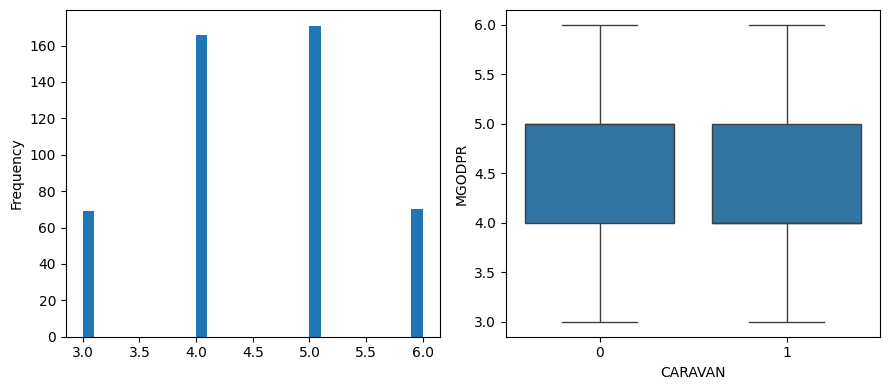

         count  mean  median   std  min  max
CARAVAN                                     
0          442  4.51     5.0  0.92    3    6
1           34  4.47     4.0  0.86    3    6 


=== MGODOV ===
 ---> Límites Outliers MGODOV 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MGODOV  0.0  2.0  2.0   -3.0    5.0         NaN       375.5 

         count  mean  median   std  min  max
CARAVAN                                     
0          578  1.05     1.0  1.06    0    5
1           44  1.09     1.0  0.88    0    3 

variable        MGODOV
long_media        True
dif_mean          0.04
dif<10%           True
considerar          NO
cambia_rango        SI
dtype: object 



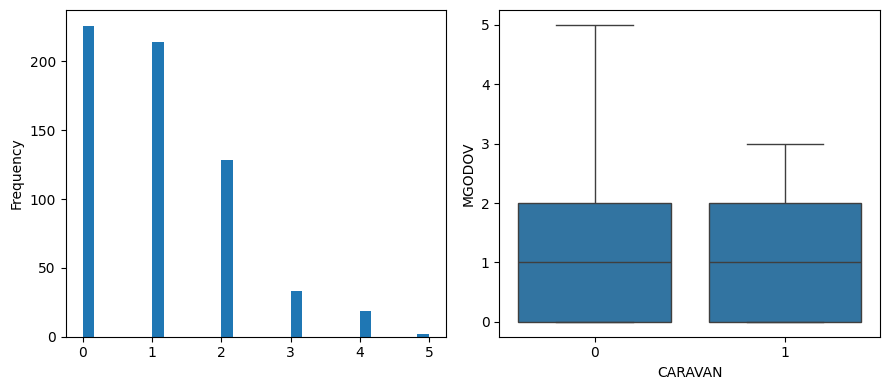

         count  mean  median   std  min  max
CARAVAN                                     
0          578  1.05     1.0  1.06    0    5
1           44  1.09     1.0  0.88    0    3 


=== MGODGE ===
 ---> Límites Outliers MGODGE 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MGODGE  2.0  4.0  2.0   -1.0    7.0         0.0       214.5 

         count  mean  median   std  min  max
CARAVAN                                     
0          578  3.37     3.0  1.64    0    7
1           45  2.82     3.0  1.48    0    5 

variable        MGODGE
long_media        True
dif_mean          0.16
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



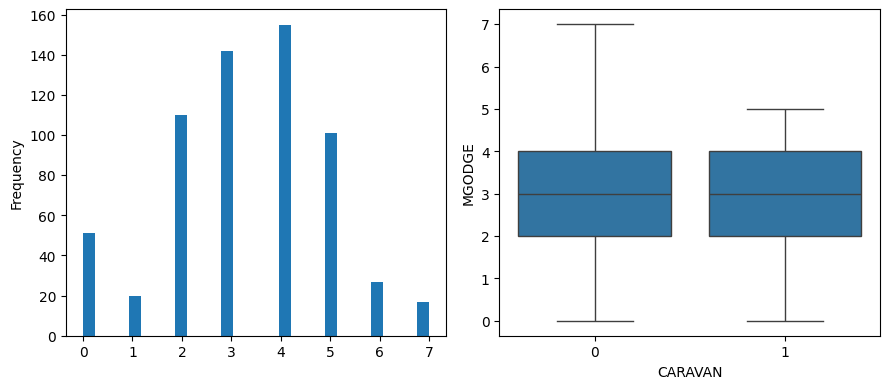

         count  mean  median   std  min  max
CARAVAN                                     
0          578  3.37     3.0  1.64    0    7
1           45  2.82     3.0  1.48    0    5 


=== MRELGE ===
 ---> Límites Outliers MRELGE 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MRELGE  5.0  7.0  2.0    2.0   10.0         0.0      126.71 

         count  mean  median   std  min  max
CARAVAN                                     
0          547  6.20     6.0  1.80    2    9
1           44  6.61     7.0  1.59    3    9 

variable        MRELGE
long_media        True
dif_mean          0.07
dif<10%           True
considerar          NO
cambia_rango        SI
dtype: object 



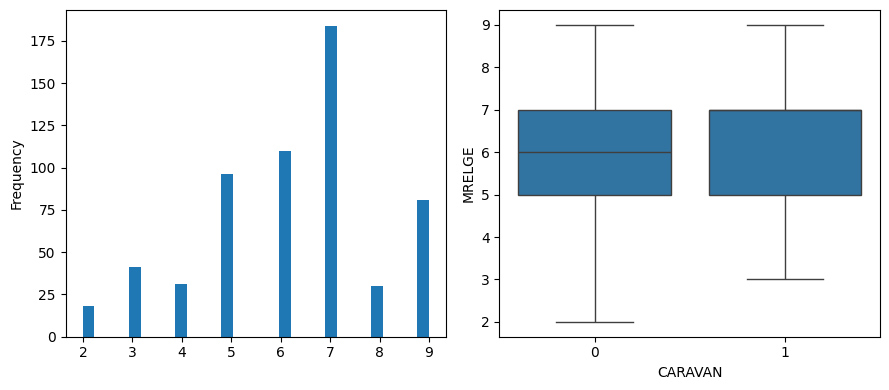

         count  mean  median   std  min  max
CARAVAN                                     
0          547  6.20     6.0  1.80    2    9
1           44  6.61     7.0  1.59    3    9 


=== MRELSA ===
 ---> Límites Outliers MRELSA 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MRELSA  0.0  2.0  2.0   -3.0    5.0         NaN       334.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          568  0.91     1.0  0.96    0    5
1           44  0.91     1.0  0.91    0    4 

variable        MRELSA
long_media        True
dif_mean           0.0
dif<10%           True
considerar          NO
cambia_rango        SI
dtype: object 



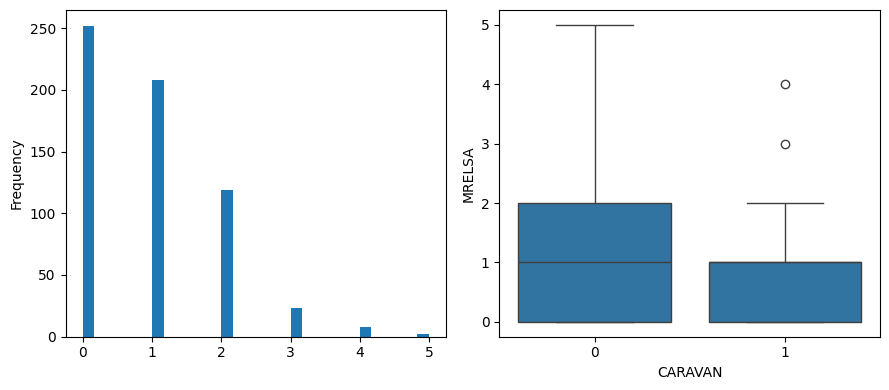

         count  mean  median   std  min  max
CARAVAN                                     
0          568  0.91     1.0  0.96    0    5
1           44  0.91     1.0  0.91    0    4 


=== MRELOV ===
 ---> Límites Outliers MRELOV 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MRELOV  1.0  3.0  2.0   -2.0    6.0         0.0      303.67 

         count  mean  median   std  min  max
CARAVAN                                     
0          557  2.31     2.0  1.64    0    6
1           45  1.89     2.0  1.45    0    5 

variable        MRELOV
long_media        True
dif_mean          0.18
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



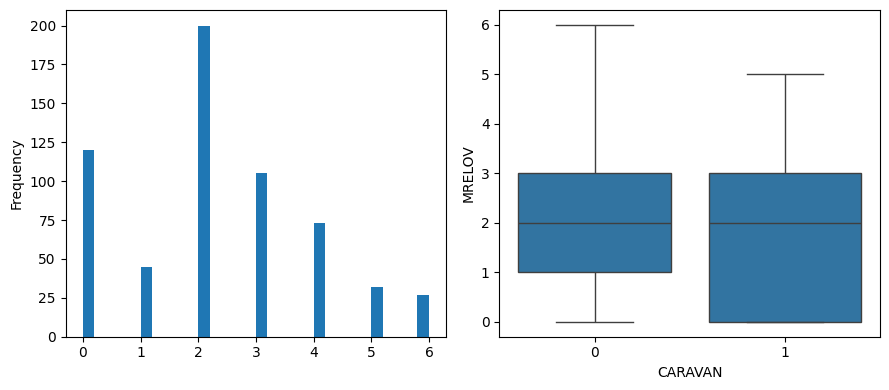

         count  mean  median   std  min  max
CARAVAN                                     
0          557  2.31     2.0  1.64    0    6
1           45  1.89     2.0  1.45    0    5 


=== MFALLEEN ===
 ---> Límites Outliers MFALLEEN 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MFALLEEN  0.0  3.0  3.0   -4.5    7.5         NaN      292.67 

         count  mean  median   std  min  max
CARAVAN                                     
0          570  2.05     2.0  1.90    0    7
1           44  1.34     1.0  1.41    0    5 

variable        MFALLEEN
long_media          True
dif_mean            0.35
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



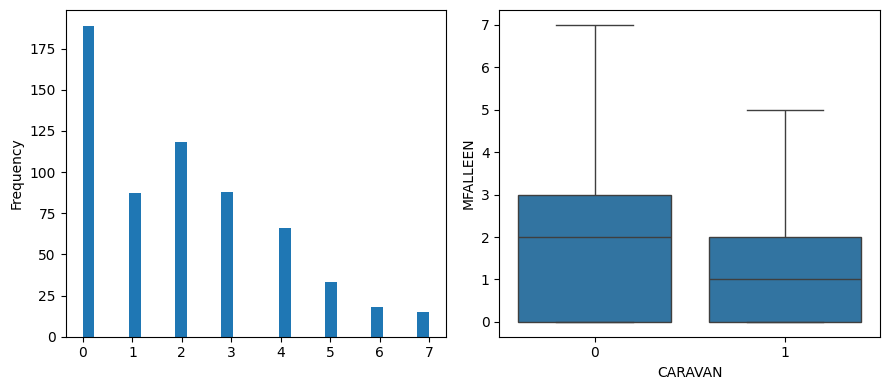

         count  mean  median   std  min  max
CARAVAN                                     
0          570  2.05     2.0  1.90    0    7
1           44  1.34     1.0  1.41    0    5 


=== MFGEKIND ===
 ---> Límites Outliers MFGEKIND 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MFGEKIND  2.0  4.0  2.0   -1.0    7.0         0.0       228.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          574  3.07     3.0  1.59    0    7
1           45  3.71     4.0  1.80    0    7 

variable        MFGEKIND
long_media          True
dif_mean            0.21
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



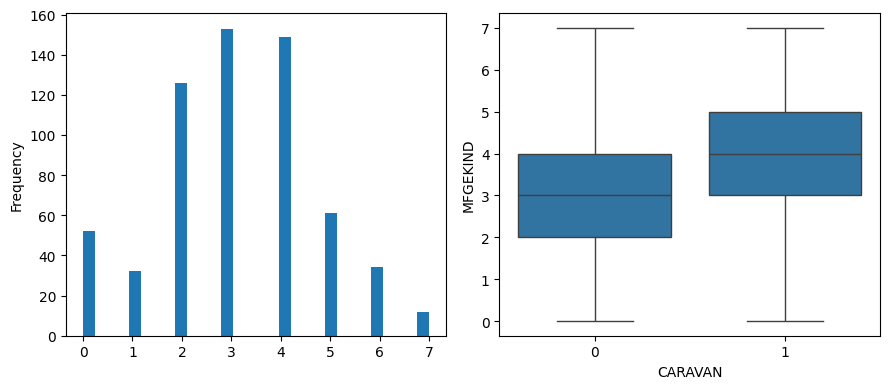

         count  mean  median   std  min  max
CARAVAN                                     
0          574  3.07     3.0  1.59    0    7
1           45  3.71     4.0  1.80    0    7 


=== MFWEKIND ===
 ---> Límites Outliers MFWEKIND 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MFWEKIND  3.0  6.0  3.0   -1.5   10.5         0.0      119.83 

         count  mean  median   std  min  max
CARAVAN                                     
0          577  4.18     4.0  2.14    0    9
1           44  4.18     4.0  2.13    1    8 

variable        MFWEKIND
long_media          True
dif_mean             0.0
dif<10%             True
considerar            NO
cambia_rango          SI
dtype: object 



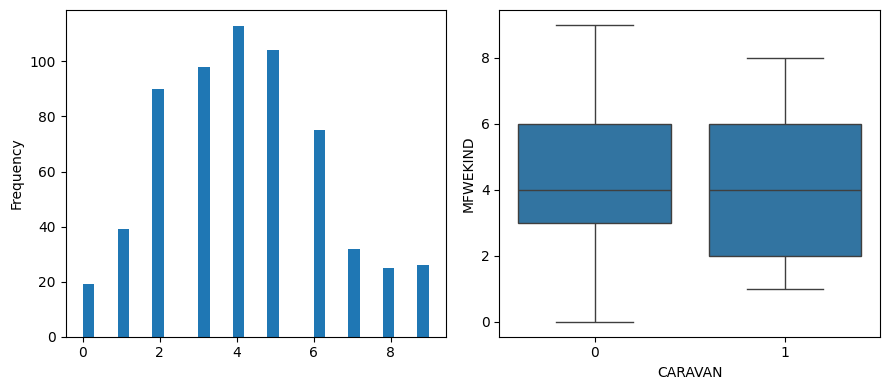

         count  mean  median   std  min  max
CARAVAN                                     
0          577  4.18     4.0  2.14    0    9
1           44  4.18     4.0  2.13    1    8 


=== MOPLHOOG ===
 ---> Límites Outliers MOPLHOOG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MOPLHOOG  0.0  2.0  2.0   -3.0    5.0         NaN       243.5 

         count  mean  median   std  min  max
CARAVAN                                     
0          560  1.31     1.0  1.37    0    5
1           41  1.73     1.0  1.48    0    5 

variable        MOPLHOOG
long_media          True
dif_mean            0.32
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



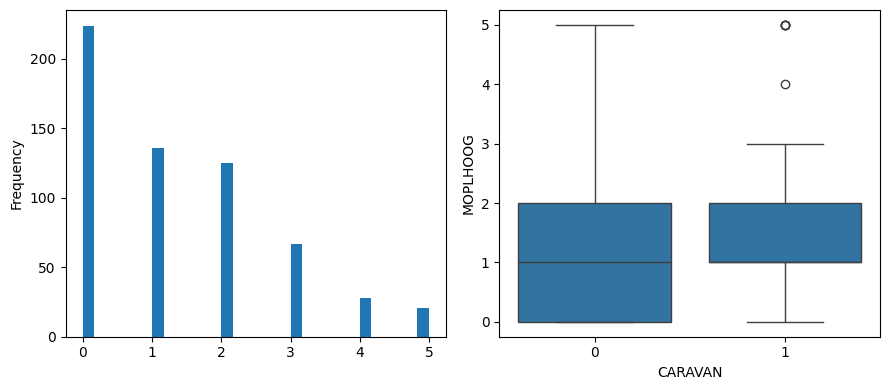

         count  mean  median   std  min  max
CARAVAN                                     
0          560  1.31     1.0  1.37    0    5
1           41  1.73     1.0  1.48    0    5 


=== MOPLMIDD ===
 ---> Límites Outliers MOPLMIDD 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MOPLMIDD  2.0  4.0  2.0   -1.0    7.0         0.0        80.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          569  3.20     3.0  1.70    0    7
1           45  3.56     4.0  1.57    0    7 

variable        MOPLMIDD
long_media          True
dif_mean            0.11
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



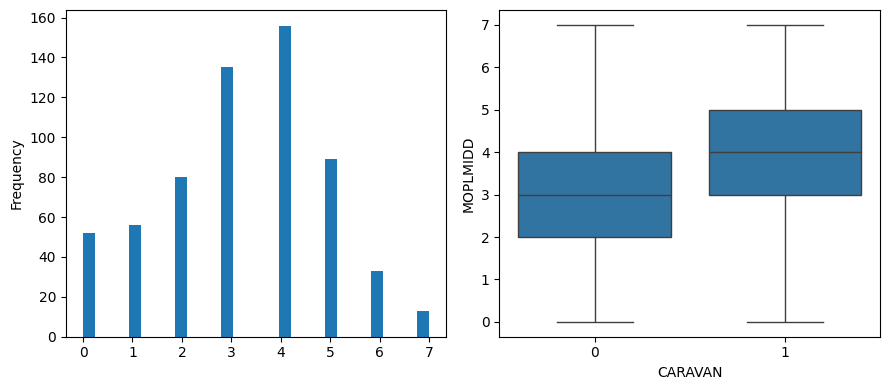

         count  mean  median   std  min  max
CARAVAN                                     
0          569  3.20     3.0  1.70    0    7
1           45  3.56     4.0  1.57    0    7 


=== MOPLLAAG ===
 ---> Límites Outliers MOPLLAAG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MOPLLAAG  3.0  6.0  3.0   -1.5   10.5         0.0      129.83 

         count  mean  median   std  min  max
CARAVAN                                     
0          575  4.61     5.0  2.32    0    9
1           45  3.69     4.0  2.25    0    9 

variable        MOPLLAAG
long_media          True
dif_mean             0.2
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



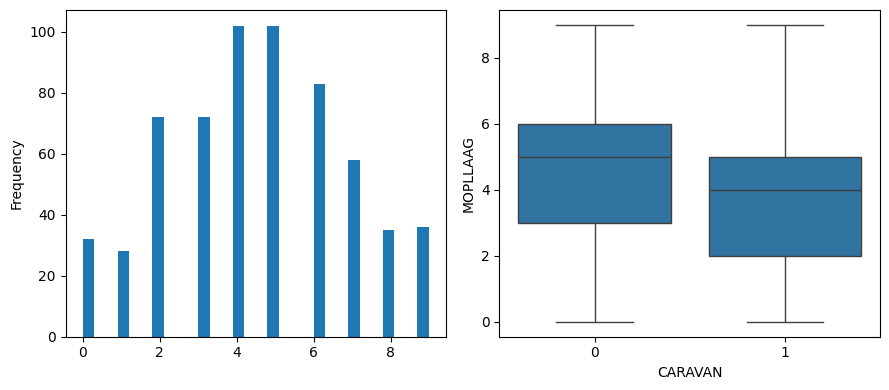

         count  mean  median   std  min  max
CARAVAN                                     
0          575  4.61     5.0  2.32    0    9
1           45  3.69     4.0  2.25    0    9 


=== MBERHOOG ===
 ---> Límites Outliers MBERHOOG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MBERHOOG  0.0  3.0  3.0   -4.5    7.5         NaN      108.67 

         count  mean  median   std  min  max
CARAVAN                                     
0          575  1.92     2.0  1.74    0    7
1           45  2.29     2.0  1.80    0    6 

variable        MBERHOOG
long_media          True
dif_mean            0.19
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



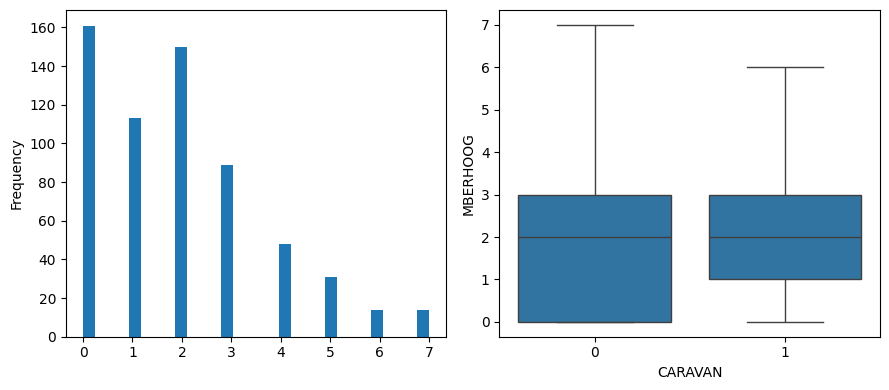

         count  mean  median   std  min  max
CARAVAN                                     
0          575  1.92     2.0  1.74    0    7
1           45  2.29     2.0  1.80    0    6 


=== MBERZELF ===
 ---> Límites Outliers MBERZELF 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MBERZELF  0.0  1.0  1.0   -1.5    2.5         NaN       839.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          567  0.35     0.0  0.60    0    2
1           44  0.57     0.0  0.66    0    2 

variable        MBERZELF
long_media          True
dif_mean            0.63
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



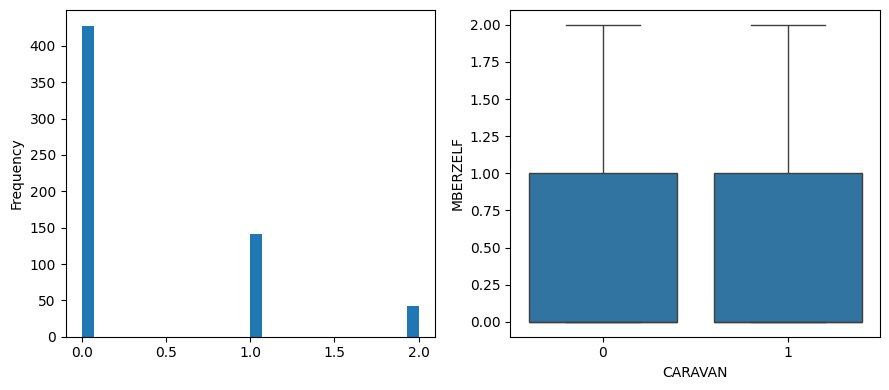

         count  mean  median   std  min  max
CARAVAN                                     
0          567  0.35     0.0  0.60    0    2
1           44  0.57     0.0  0.66    0    2 


=== MBERMIDD ===
 ---> Límites Outliers MBERMIDD 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MBERMIDD  2.0  4.0  2.0   -1.0    7.0         0.0       175.5 

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.69     3.0  1.73    0    7
1           45  3.07     3.0  1.92    0    7 

variable        MBERMIDD
long_media          True
dif_mean            0.14
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



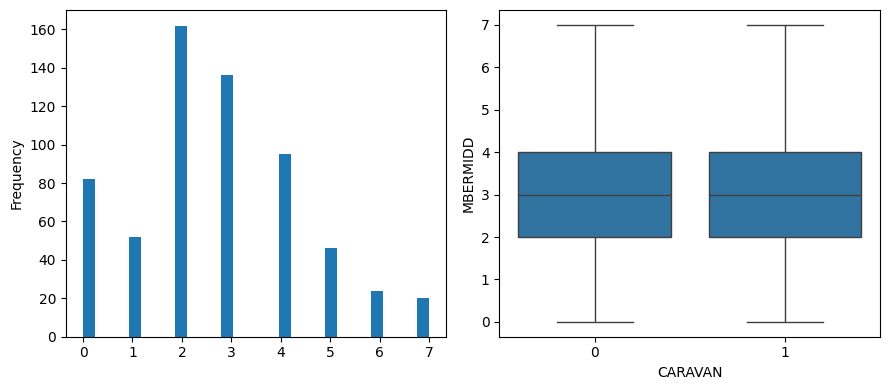

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.69     3.0  1.73    0    7
1           45  3.07     3.0  1.92    0    7 


=== MBERARBG ===
 ---> Límites Outliers MBERARBG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MBERARBG  1.0  3.0  2.0   -2.0    6.0         0.0      290.33 

         count  mean  median  std  min  max
CARAVAN                                    
0          562  2.11     2.0  1.6    0    6
1           42  1.81     1.5  1.5    0    5 

variable        MBERARBG
long_media          True
dif_mean            0.14
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



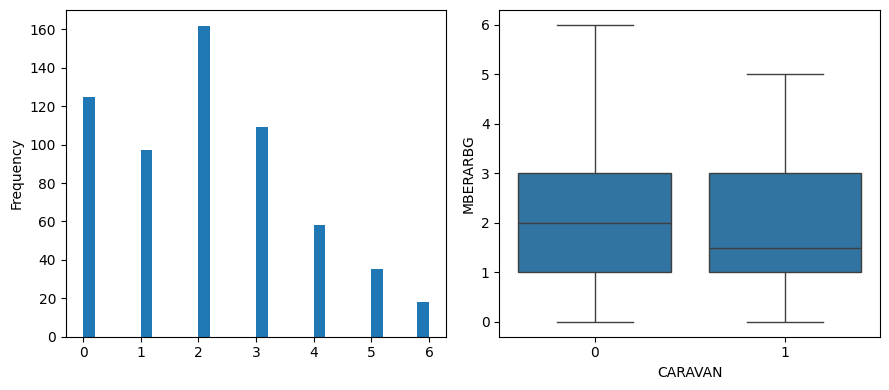

         count  mean  median  std  min  max
CARAVAN                                    
0          562  2.11     2.0  1.6    0    6
1           42  1.81     1.5  1.5    0    5 


=== MBERARBO ===
 ---> Límites Outliers MBERARBO 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MBERARBO  1.0  3.0  2.0   -2.0    6.0         0.0      107.67 

         count  mean  median   std  min  max
CARAVAN                                     
0          569  2.31     2.0  1.57    0    6
1           45  1.69     2.0  1.29    0    5 

variable        MBERARBO
long_media          True
dif_mean            0.27
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



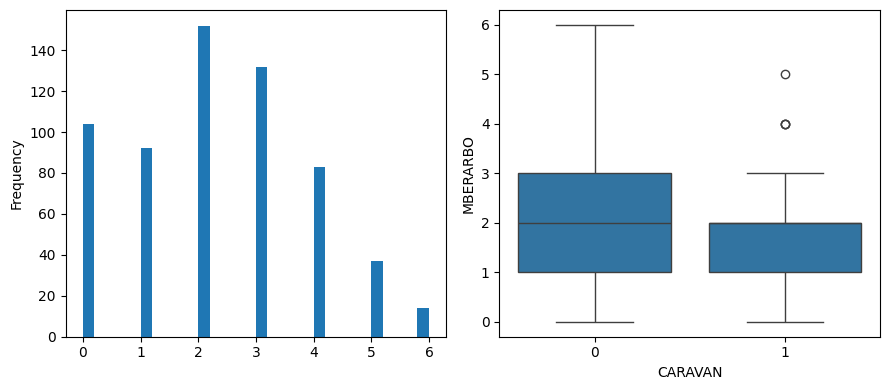

         count  mean  median   std  min  max
CARAVAN                                     
0          569  2.31     2.0  1.57    0    6
1           45  1.69     2.0  1.29    0    5 


=== MSKB1 ===
 ---> Límites Outliers MSKB1 
         Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MSKB1  0.0  2.0  2.0   -3.0    5.0         NaN     28719.5 

         count  mean  median   std  min  max
CARAVAN                                     
0          567  1.51     1.0  1.27    0    5
1           43  1.44     1.0  1.16    0    5 

variable        MSKB1
long_media       True
dif_mean         0.05
dif<10%          True
considerar         NO
cambia_rango       NO
dtype: object 



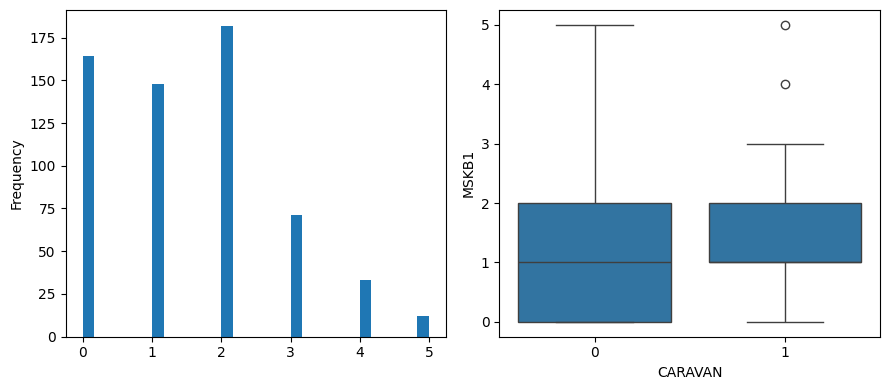

         count  mean  median   std  min  max
CARAVAN                                     
0          567  1.51     1.0  1.27    0    5
1           43  1.44     1.0  1.16    0    5 


=== MSKB2 ===
 ---> Límites Outliers MSKB2 
         Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MSKB2  1.0  3.0  2.0   -2.0    6.0         0.0       228.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.08     2.0  1.51    0    6
1           45  2.13     2.0  1.29    0    4 

variable        MSKB2
long_media       True
dif_mean         0.02
dif<10%          True
considerar         NO
cambia_rango       SI
dtype: object 



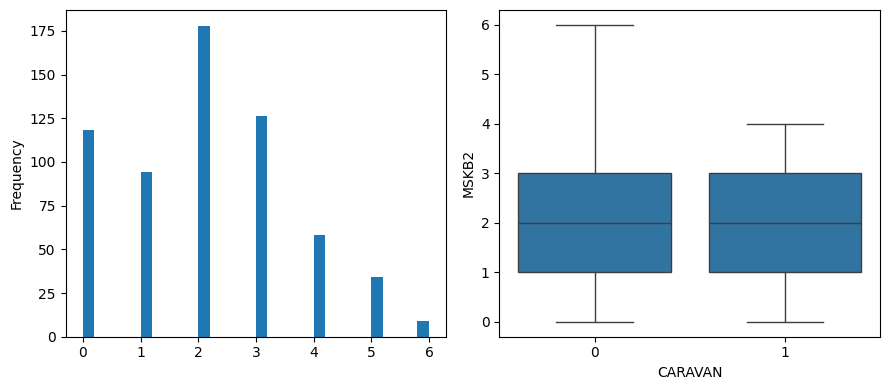

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.08     2.0  1.51    0    6
1           45  2.13     2.0  1.29    0    4 


=== MSKC ===
 ---> Límites Outliers MSKC 
        Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MSKC  2.0  5.0  3.0   -2.5    9.5         0.0      1201.2 

         count  mean  median   std  min  max
CARAVAN                                     
0          575  3.80     4.0  1.94    0    9
1           45  3.56     3.0  2.20    0    9 

variable        MSKC
long_media      True
dif_mean        0.06
dif<10%         True
considerar        NO
cambia_rango      NO
dtype: object 



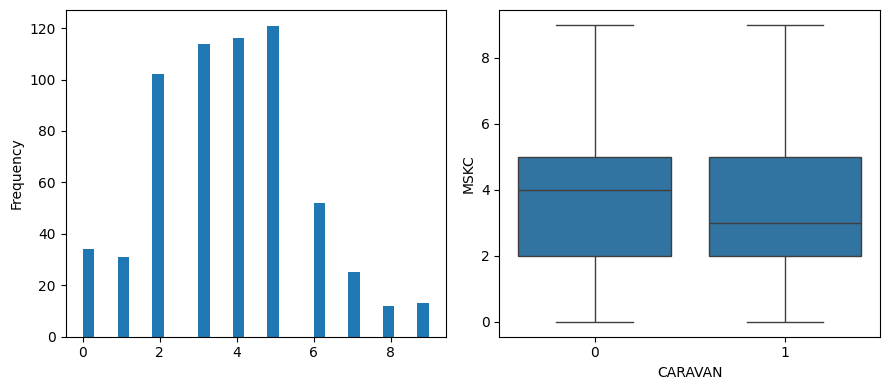

         count  mean  median   std  min  max
CARAVAN                                     
0          575  3.80     4.0  1.94    0    9
1           45  3.56     3.0  2.20    0    9 


=== MSKD ===
 ---> Límites Outliers MSKD 
        Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MSKD  0.0  2.0  2.0   -3.0    5.0         NaN       386.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          572  1.15     1.0  1.31    0    5
1           44  0.75     1.0  0.92    0    4 

variable         MSKD
long_media       True
dif_mean         0.35
dif<10%         False
considerar         SI
cambia_rango       SI
dtype: object 



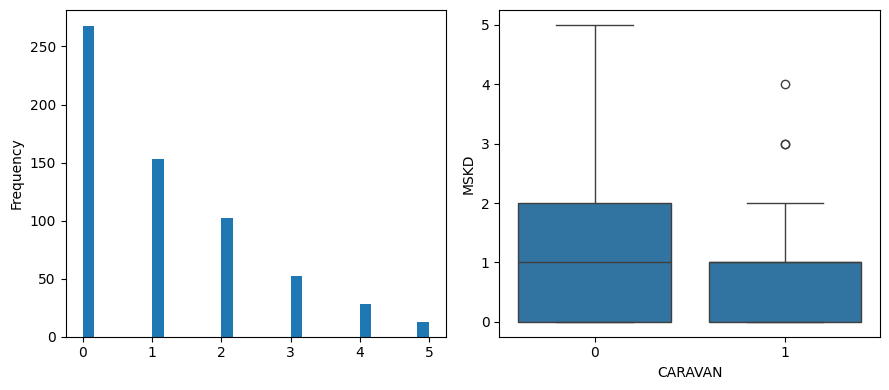

         count  mean  median   std  min  max
CARAVAN                                     
0          572  1.15     1.0  1.31    0    5
1           44  0.75     1.0  0.92    0    4 


=== MHHUUR ===
 ---> Límites Outliers MHHUUR 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MHHUUR  2.0  7.0  5.0   -5.5   14.5         0.0       82.29 

         count  mean  median   std  min  max
CARAVAN                                     
0          578  4.34     4.0  3.10    0    9
1           44  2.84     2.5  2.43    0    9 

variable        MHHUUR
long_media        True
dif_mean          0.35
dif<10%          False
considerar          SI
cambia_rango        NO
dtype: object 



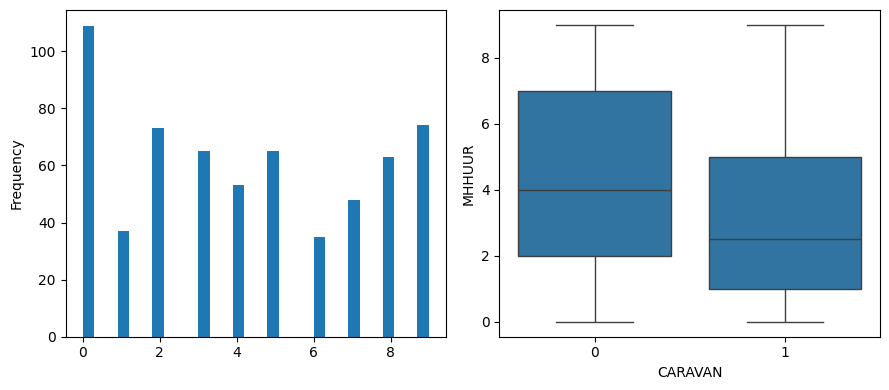

         count  mean  median   std  min  max
CARAVAN                                     
0          578  4.34     4.0  3.10    0    9
1           44  2.84     2.5  2.43    0    9 


=== MHKOOP ===
 ---> Límites Outliers MHKOOP 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MHKOOP  2.0  7.0  5.0   -5.5   14.5         0.0        87.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          574  4.68     5.0  3.11    0    9
1           45  6.11     6.0  2.42    0    9 

variable        MHKOOP
long_media        True
dif_mean          0.31
dif<10%          False
considerar          SI
cambia_rango        NO
dtype: object 



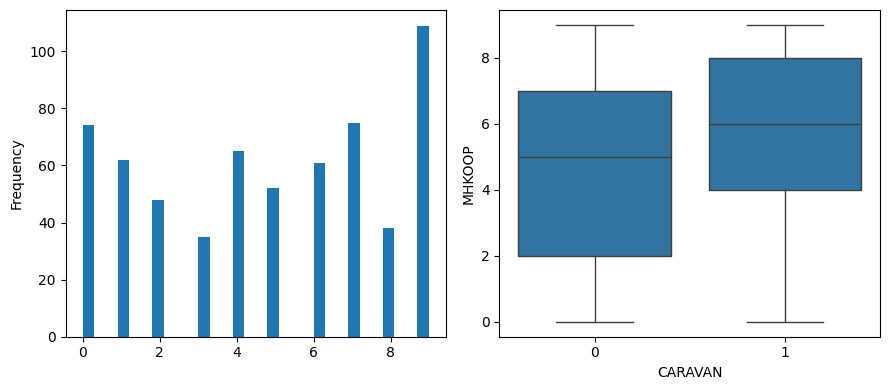

         count  mean  median   std  min  max
CARAVAN                                     
0          574  4.68     5.0  3.11    0    9
1           45  6.11     6.0  2.42    0    9 


=== MAUT1 ===
 ---> Límites Outliers MAUT1 
         Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MAUT1  5.0  7.0  2.0    2.0   10.0         0.0      125.43 

         count  mean  median   std  min  max
CARAVAN                                     
0          569  6.03     6.0  1.54    2    9
1           43  6.40     6.0  1.26    3    9 

variable        MAUT1
long_media       True
dif_mean         0.06
dif<10%          True
considerar         NO
cambia_rango       SI
dtype: object 



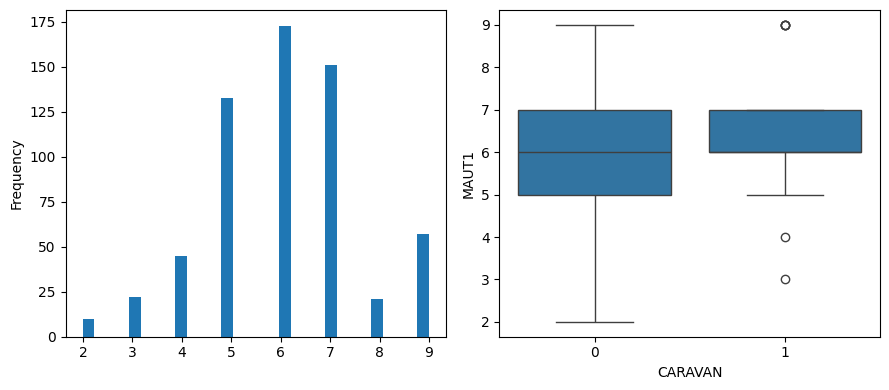

         count  mean  median   std  min  max
CARAVAN                                     
0          569  6.03     6.0  1.54    2    9
1           43  6.40     6.0  1.26    3    9 


=== MAUT2 ===
 ---> Límites Outliers MAUT2 
         Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MAUT2  0.0  2.0  2.0   -3.0    5.0         NaN       156.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          577  1.28     1.0  1.19    0    5
1           42  1.38     1.0  0.99    0    4 

variable        MAUT2
long_media       True
dif_mean         0.08
dif<10%          True
considerar         NO
cambia_rango       SI
dtype: object 



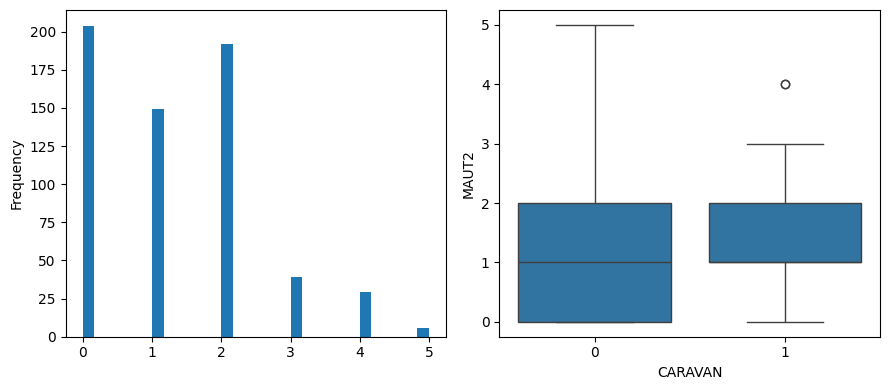

         count  mean  median   std  min  max
CARAVAN                                     
0          577  1.28     1.0  1.19    0    5
1           42  1.38     1.0  0.99    0    4 


=== MAUT0 ===
 ---> Límites Outliers MAUT0 
         Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MAUT0  1.0  3.0  2.0   -2.0    6.0         0.0       310.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          568  1.95     2.0  1.53    0    6
1           45  1.51     2.0  1.18    0    4 

variable        MAUT0
long_media       True
dif_mean         0.23
dif<10%         False
considerar         SI
cambia_rango       SI
dtype: object 



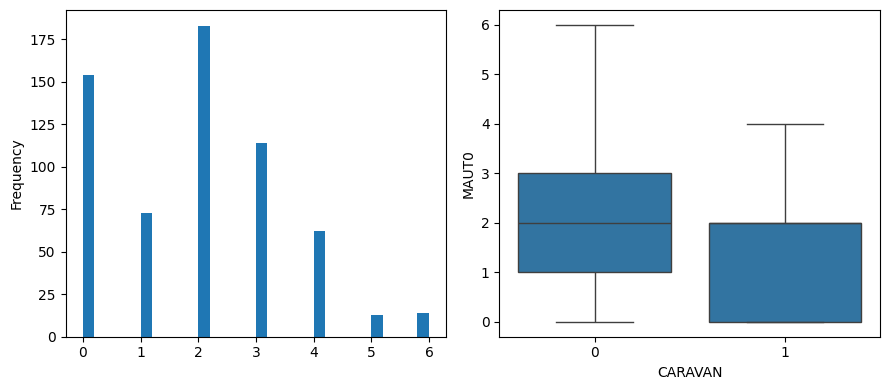

         count  mean  median   std  min  max
CARAVAN                                     
0          568  1.95     2.0  1.53    0    6
1           45  1.51     2.0  1.18    0    4 


=== MZFONDS ===
 ---> Límites Outliers MZFONDS 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MZFONDS  5.0  8.0  3.0    0.5   12.5         0.0        88.5 

         count  mean  median   std  min  max
CARAVAN                                     
0          568  6.40     7.0  1.94    1    9
1           43  5.95     7.0  2.03    2    9 

variable        MZFONDS
long_media         True
dif_mean           0.07
dif<10%            True
considerar           NO
cambia_rango         SI
dtype: object 



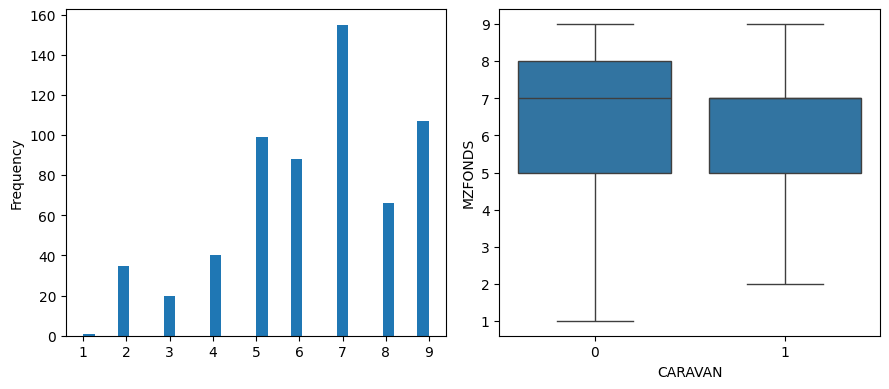

         count  mean  median   std  min  max
CARAVAN                                     
0          568  6.40     7.0  1.94    1    9
1           43  5.95     7.0  2.03    2    9 


=== MZPART ===
 ---> Límites Outliers MZPART 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MZPART  1.0  4.0  3.0   -3.5    8.5         0.0      169.75 

         count  mean  median   std  min  max
CARAVAN                                     
0          568  2.59     2.0  1.94    0    8
1           43  3.05     2.0  2.03    0    7 

variable        MZPART
long_media        True
dif_mean          0.18
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



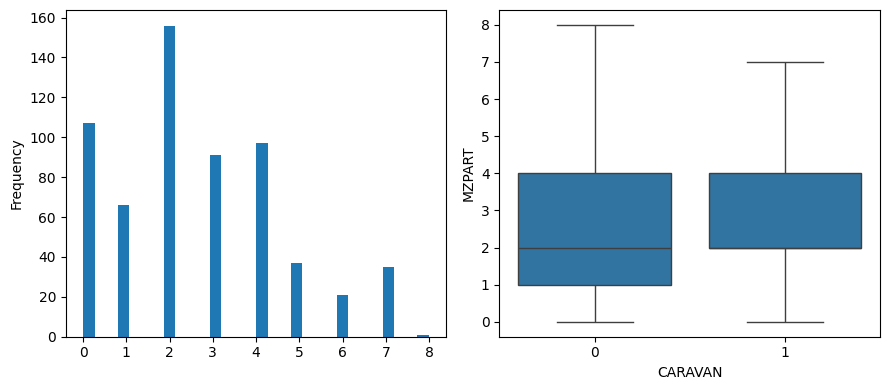

         count  mean  median   std  min  max
CARAVAN                                     
0          568  2.59     2.0  1.94    0    8
1           43  3.05     2.0  2.03    0    7 


=== MINKM30 ===
 ---> Límites Outliers MINKM30 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MINKM30  1.0  4.0  3.0   -3.5    8.5         0.0      232.75 

         count  mean  median   std  min  max
CARAVAN                                     
0          571  2.61     2.0  2.07    0    8
1           44  1.98     2.0  1.70    0    6 

variable        MINKM30
long_media         True
dif_mean           0.24
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



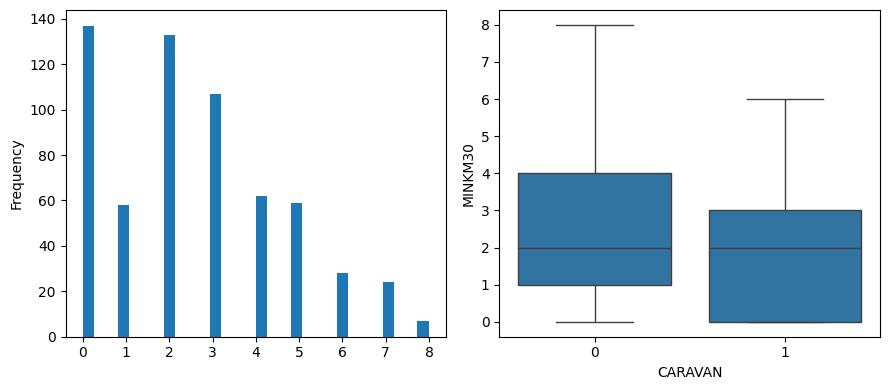

         count  mean  median   std  min  max
CARAVAN                                     
0          571  2.61     2.0  2.07    0    8
1           44  1.98     2.0  1.70    0    6 


=== MINK3045 ===
 ---> Límites Outliers MINK3045 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MINK3045  2.0  5.0  3.0   -2.5    9.5         0.0       178.2 

         count  mean  median   std  min  max
CARAVAN                                     
0          576  3.53     4.0  1.91    0    9
1           45  3.38     3.0  1.67    0    7 

variable        MINK3045
long_media          True
dif_mean            0.04
dif<10%             True
considerar            NO
cambia_rango          SI
dtype: object 



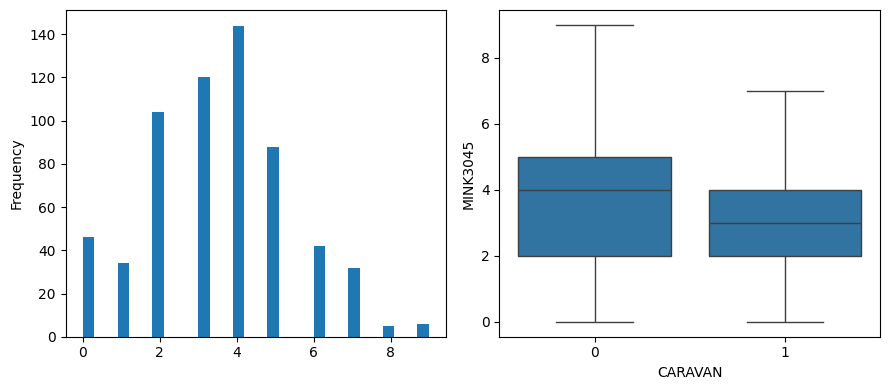

         count  mean  median   std  min  max
CARAVAN                                     
0          576  3.53     4.0  1.91    0    9
1           45  3.38     3.0  1.67    0    7 


=== MINK4575 ===
 ---> Límites Outliers MINK4575 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MINK4575  1.0  4.0  3.0   -3.5    8.5         0.0      232.75 

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.58     3.0  1.80    0    8
1           44  2.93     3.0  1.87    0    8 

variable        MINK4575
long_media          True
dif_mean            0.14
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



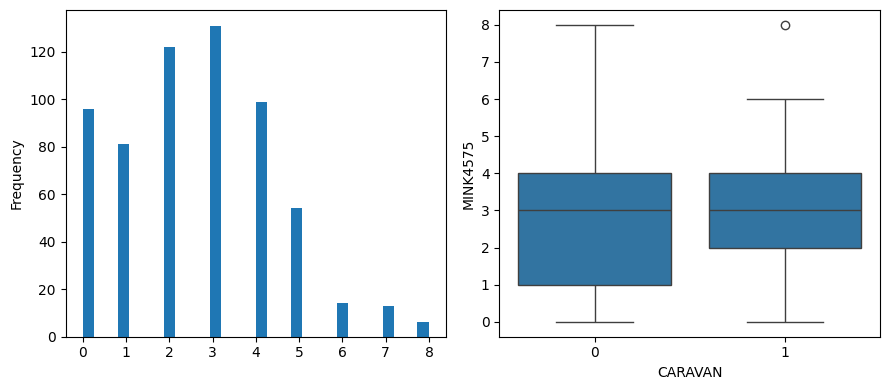

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.58     3.0  1.80    0    8
1           44  2.93     3.0  1.87    0    8 


=== MINK7512 ===
 ---> Límites Outliers MINK7512 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MINK7512  0.0  1.0  1.0   -1.5    2.5         NaN       929.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          528  0.52     0.0  0.72    0    2
1           38  1.03     1.0  0.79    0    2 

variable        MINK7512
long_media          True
dif_mean            0.98
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



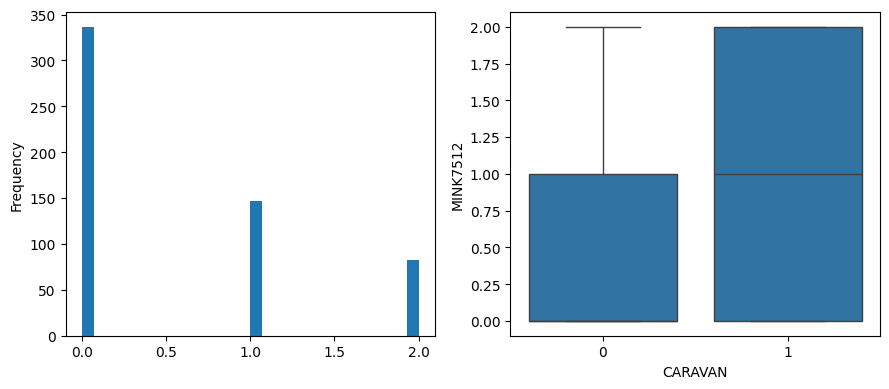

         count  mean  median   std  min  max
CARAVAN                                     
0          528  0.52     0.0  0.72    0    2
1           38  1.03     1.0  0.79    0    2 


=== MINK123M ===
 ---> Límites Outliers MINK123M 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MINK123M  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          480   0.0     0.0  0.0    0    0
1           36   0.0     0.0  0.0    0    0 

variable        MINK123M
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


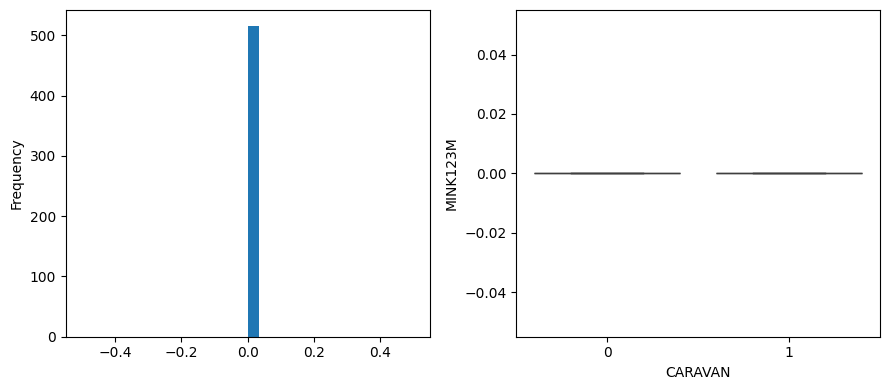

         count  mean  median  std  min  max
CARAVAN                                    
0          480   0.0     0.0  0.0    0    0
1           36   0.0     0.0  0.0    0    0 


=== MINKGEM ===
 ---> Límites Outliers MINKGEM 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
MINKGEM  3.0  4.0  1.0    1.5    5.5         0.0      229.75 

         count  mean  median   std  min  max
CARAVAN                                     
0          517  3.47     3.0  0.92    2    5
1           36  3.89     4.0  0.85    2    5 

variable        MINKGEM
long_media         True
dif_mean           0.12
dif<10%           False
considerar           SI
cambia_rango         NO
dtype: object 



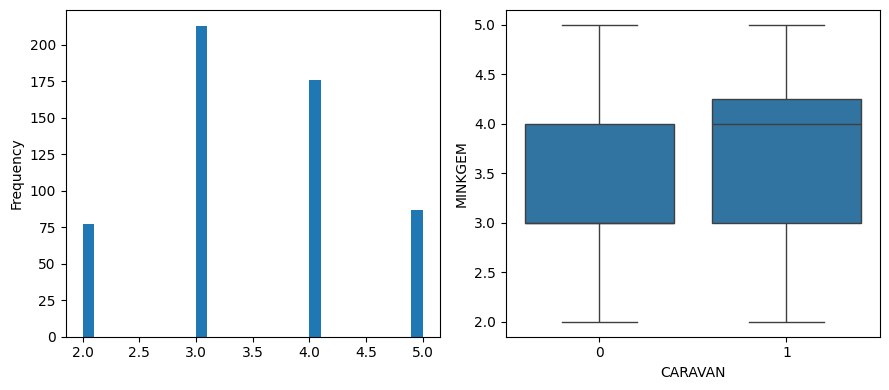

         count  mean  median   std  min  max
CARAVAN                                     
0          517  3.47     3.0  0.92    2    5
1           36  3.89     4.0  0.85    2    5 


=== PWABEDR ===
 ---> Límites Outliers PWABEDR 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PWABEDR  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          575   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        PWABEDR
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


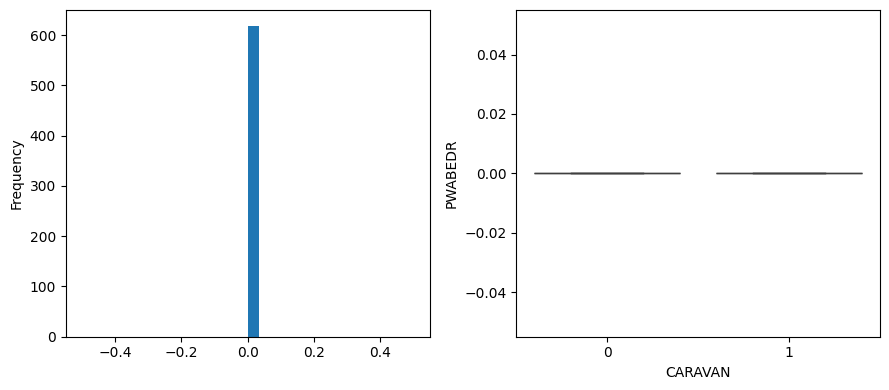

         count  mean  median  std  min  max
CARAVAN                                    
0          575   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== PWALAND ===
 ---> Límites Outliers PWALAND 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PWALAND  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          576   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        PWALAND
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


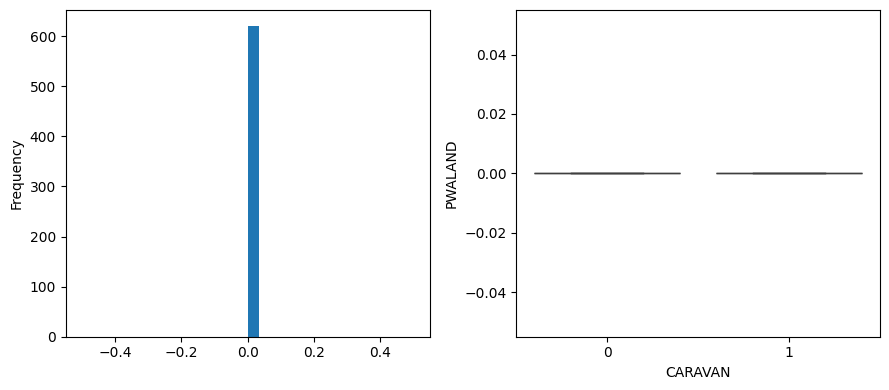

         count  mean  median  std  min  max
CARAVAN                                    
0          576   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== PPERSAUT ===
 ---> Límites Outliers PPERSAUT 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PPERSAUT  0.0  6.0  6.0   -9.0   15.0         NaN        98.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          579  3.48     5.0  2.89    0    7
1           44  5.14     6.0  2.08    0    6 

variable        PPERSAUT
long_media          True
dif_mean            0.48
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



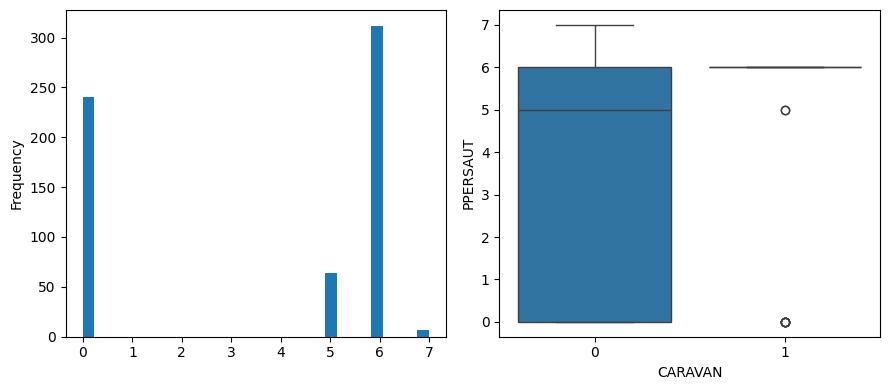

         count  mean  median   std  min  max
CARAVAN                                     
0          579  3.48     5.0  2.89    0    7
1           44  5.14     6.0  2.08    0    6 


=== PBESAUT ===
 ---> Límites Outliers PBESAUT 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PBESAUT  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          575   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        PBESAUT
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


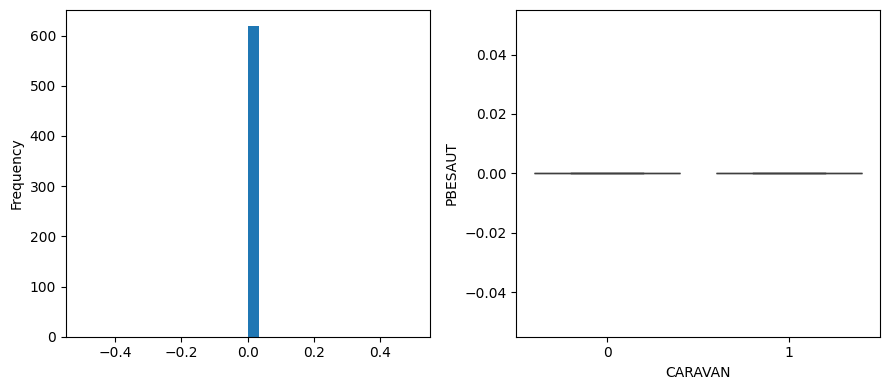

         count  mean  median  std  min  max
CARAVAN                                    
0          575   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== PMOTSCO ===
 ---> Límites Outliers PMOTSCO 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PMOTSCO  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          557   0.0     0.0  0.0    0    0
1           39   0.0     0.0  0.0    0    0 

variable        PMOTSCO
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


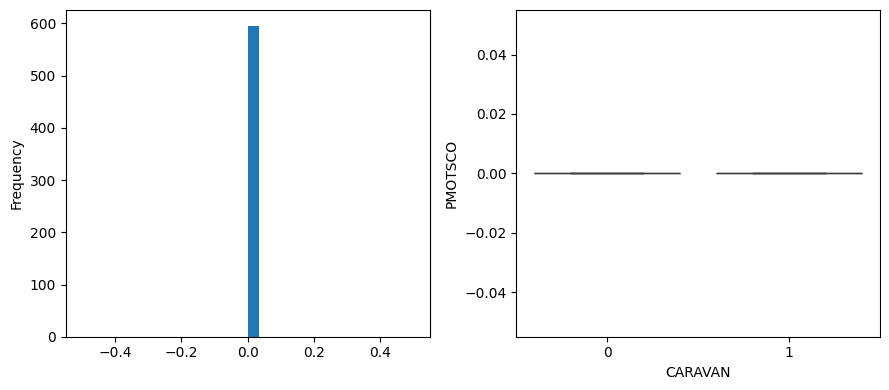

         count  mean  median  std  min  max
CARAVAN                                    
0          557   0.0     0.0  0.0    0    0
1           39   0.0     0.0  0.0    0    0 


=== PVRAAUT ===
 ---> Límites Outliers PVRAAUT 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PVRAAUT  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          579   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        PVRAAUT
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


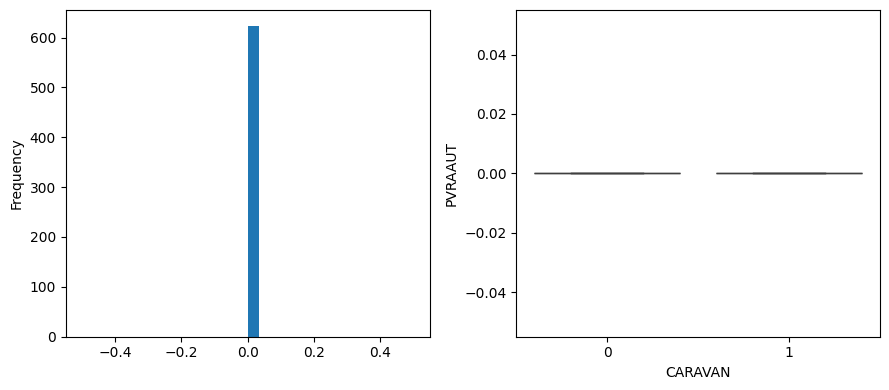

         count  mean  median  std  min  max
CARAVAN                                    
0          579   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== PAANHANG ===
 ---> Límites Outliers PAANHANG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PAANHANG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          570   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        PAANHANG
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


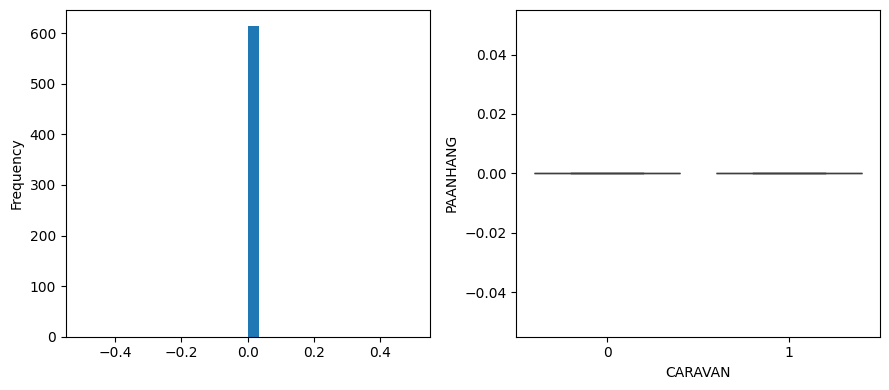

         count  mean  median  std  min  max
CARAVAN                                    
0          570   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== PTRACTOR ===
 ---> Límites Outliers PTRACTOR 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PTRACTOR  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        PTRACTOR
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


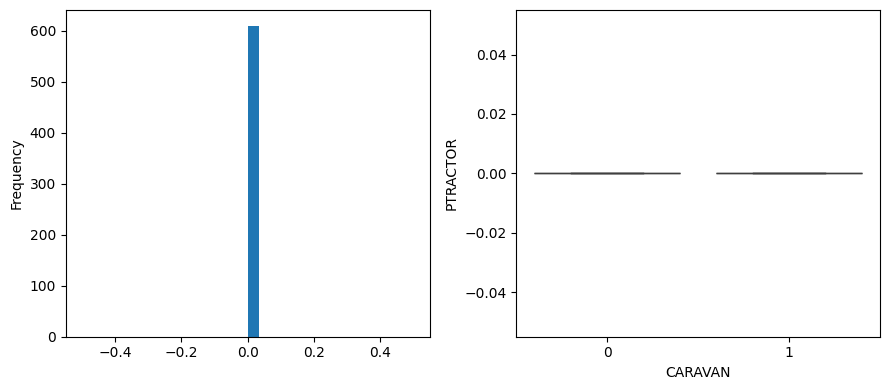

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== PWERKT ===
 ---> Límites Outliers PWERKT 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PWERKT  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        PWERKT
long_media       False
dif_mean           NaN
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


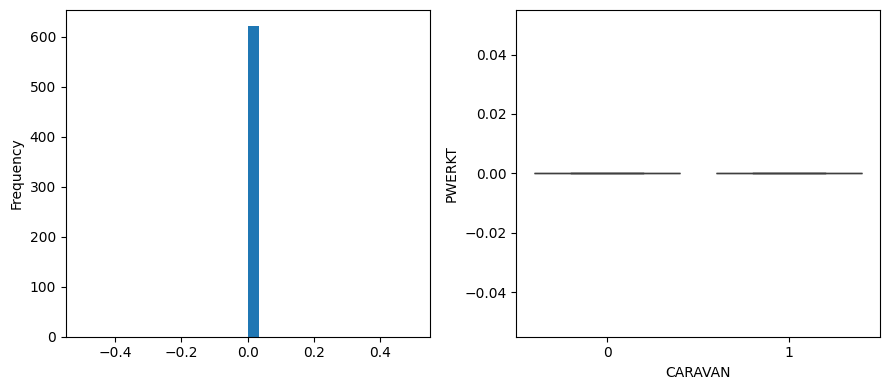

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== PBROM ===
 ---> Límites Outliers PBROM 
         Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PBROM  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        PBROM
long_media      False
dif_mean          NaN
dif<10%         False
considerar         SI
cambia_rango       SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


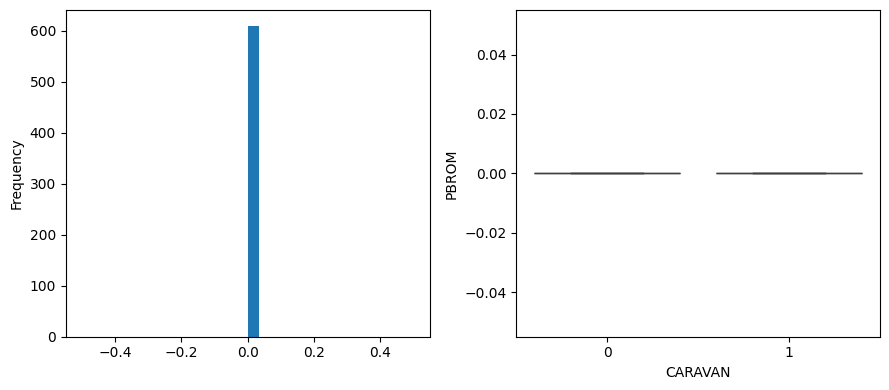

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== PLEVEN ===
 ---> Límites Outliers PLEVEN 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PLEVEN  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          525   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 

variable        PLEVEN
long_media       False
dif_mean           NaN
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


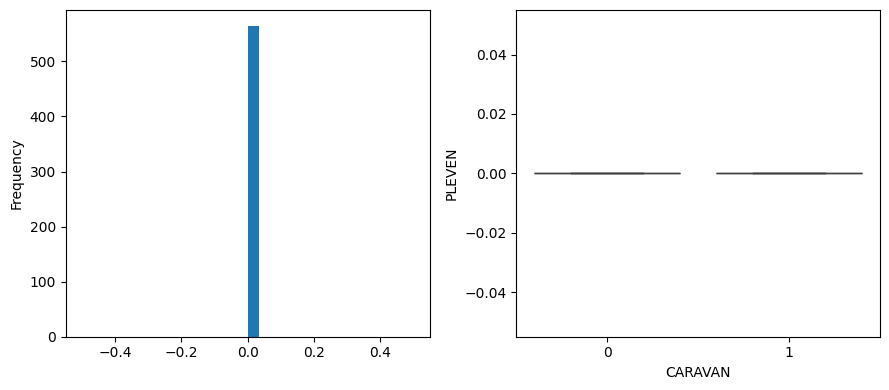

         count  mean  median  std  min  max
CARAVAN                                    
0          525   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 


=== PPERSONG ===
 ---> Límites Outliers PPERSONG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PPERSONG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          574   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        PPERSONG
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


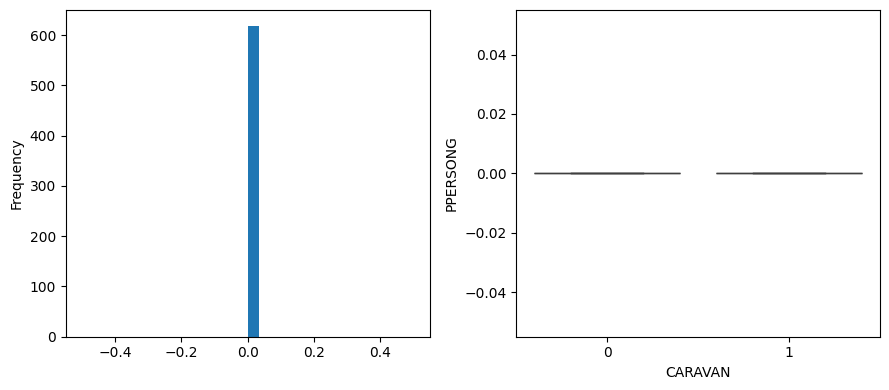

         count  mean  median  std  min  max
CARAVAN                                    
0          574   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== PGEZONG ===
 ---> Límites Outliers PGEZONG 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PGEZONG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           43   0.0     0.0  0.0    0    0 

variable        PGEZONG
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


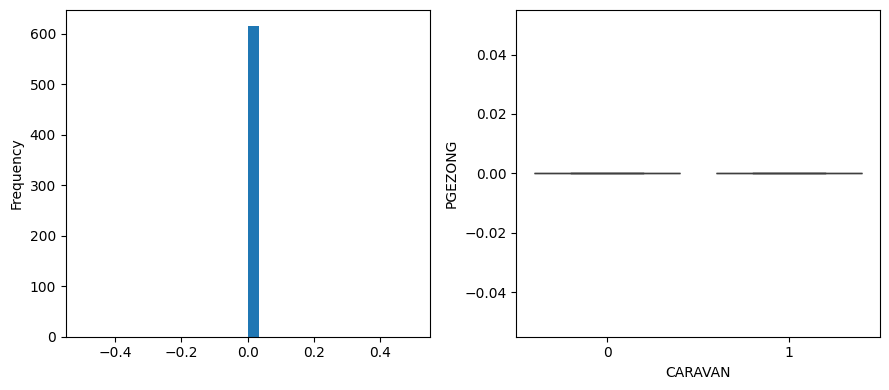

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           43   0.0     0.0  0.0    0    0 


=== PWAOREG ===
 ---> Límites Outliers PWAOREG 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PWAOREG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        PWAOREG
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


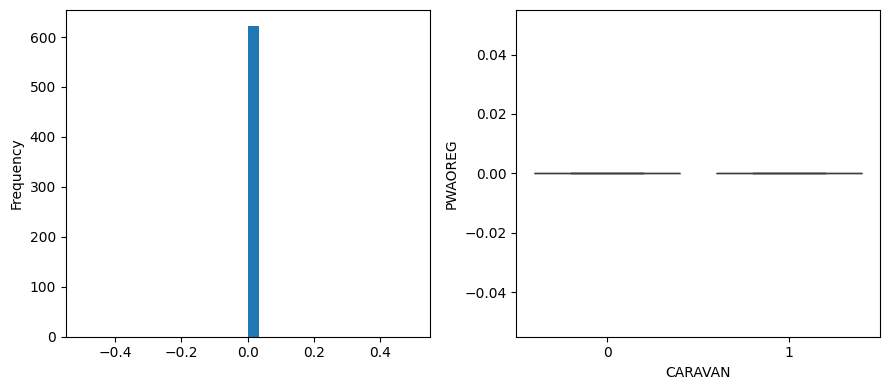

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== PBRAND ===
 ---> Límites Outliers PBRAND 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PBRAND  2.0  4.0  2.0   -1.0    7.0         0.0      216.25 

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.94     3.0  1.42    0    6
1           45  3.38     4.0  1.28    0    5 

variable        PBRAND
long_media        True
dif_mean          0.15
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



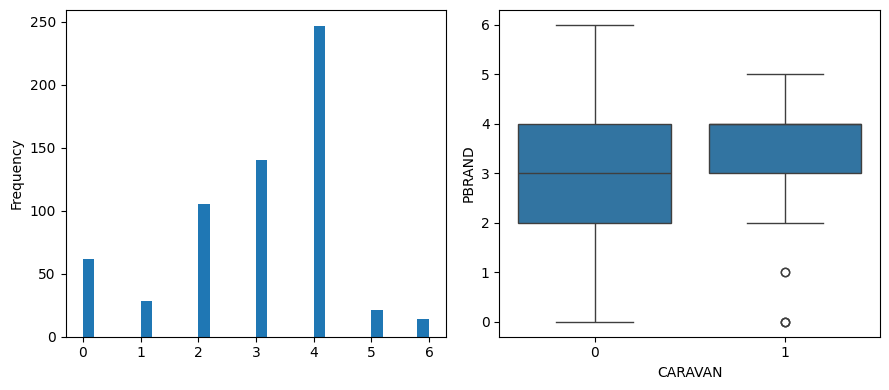

         count  mean  median   std  min  max
CARAVAN                                     
0          572  2.94     3.0  1.42    0    6
1           45  3.38     4.0  1.28    0    5 


=== PZEILPL ===
 ---> Límites Outliers PZEILPL 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PZEILPL  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          580   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        PZEILPL
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


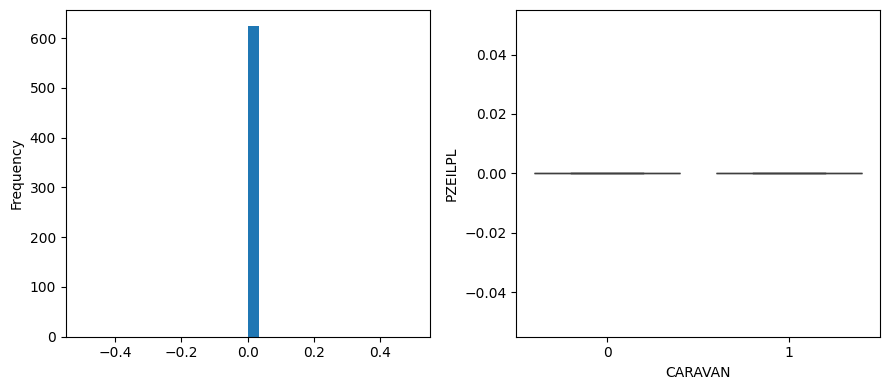

         count  mean  median  std  min  max
CARAVAN                                    
0          580   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== PPLEZIER ===
 ---> Límites Outliers PPLEZIER 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PPLEZIER  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        PPLEZIER
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


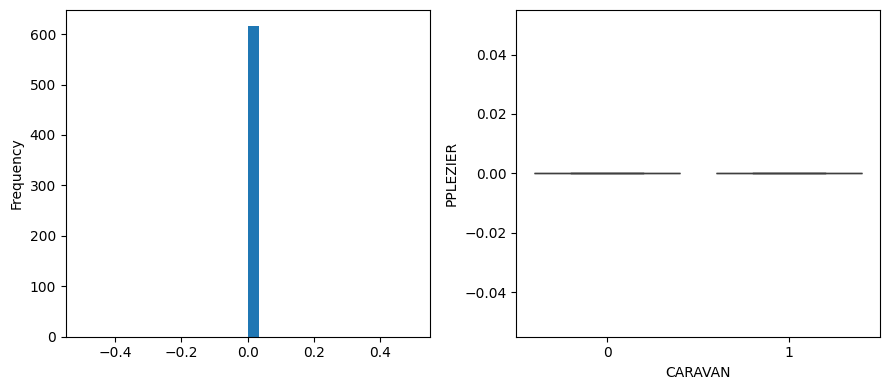

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== PFIETS ===
 ---> Límites Outliers PFIETS 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PFIETS  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          565   0.0     0.0  0.0    0    0
1           41   0.0     0.0  0.0    0    0 

variable        PFIETS
long_media       False
dif_mean           NaN
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


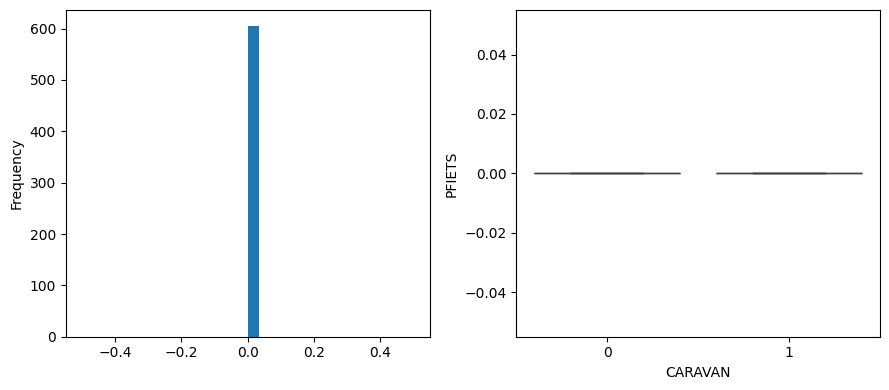

         count  mean  median  std  min  max
CARAVAN                                    
0          565   0.0     0.0  0.0    0    0
1           41   0.0     0.0  0.0    0    0 


=== PINBOED ===
 ---> Límites Outliers PINBOED 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PINBOED  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          569   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        PINBOED
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


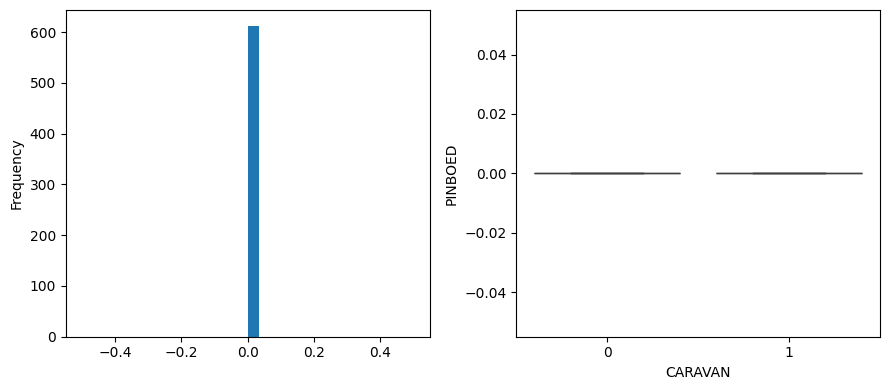

         count  mean  median  std  min  max
CARAVAN                                    
0          569   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== PBYSTAND ===
 ---> Límites Outliers PBYSTAND 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
PBYSTAND  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          568   0.0     0.0  0.0    0    0
1           42   0.0     0.0  0.0    0    0 

variable        PBYSTAND
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


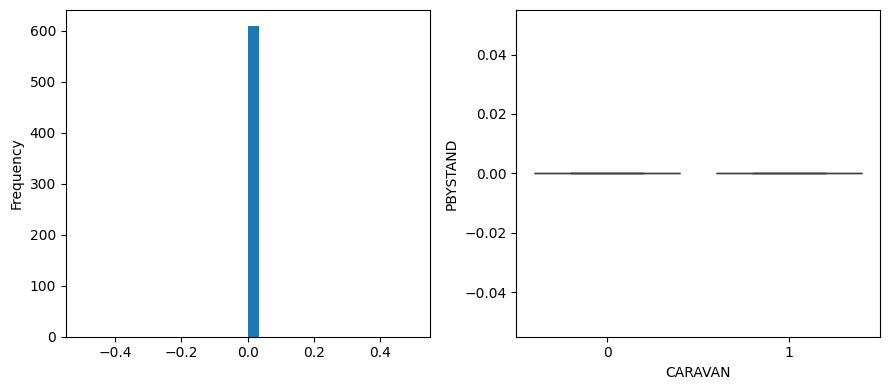

         count  mean  median  std  min  max
CARAVAN                                    
0          568   0.0     0.0  0.0    0    0
1           42   0.0     0.0  0.0    0    0 


=== AWABEDR ===
 ---> Límites Outliers AWABEDR 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AWABEDR  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          574   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        AWABEDR
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


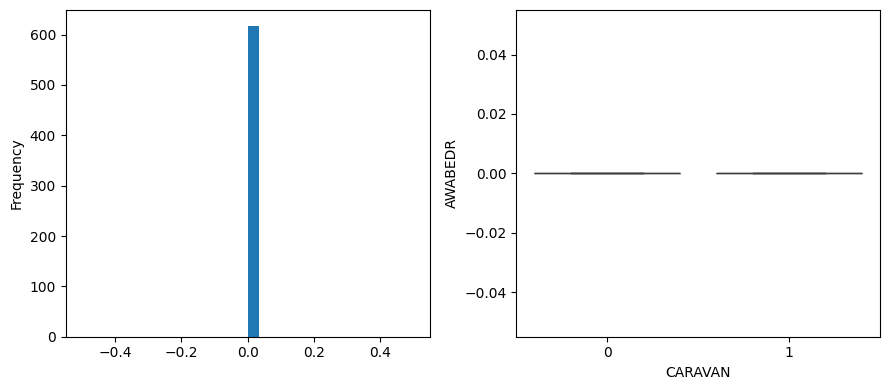

         count  mean  median  std  min  max
CARAVAN                                    
0          574   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== AWALAND ===
 ---> Límites Outliers AWALAND 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AWALAND  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        AWALAND
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


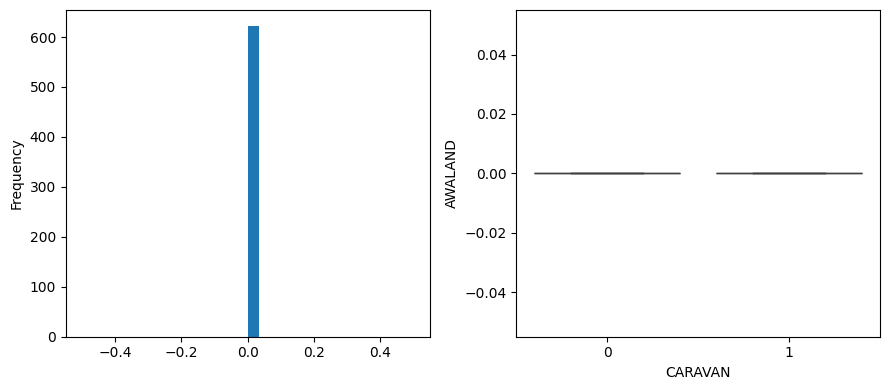

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== APERSAUT ===
 ---> Límites Outliers APERSAUT 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
APERSAUT  0.0  1.0  1.0   -1.5    2.5         NaN       846.0 

         count  mean  median   std  min  max
CARAVAN                                     
0          575  0.64     1.0  0.57    0    2
1           44  1.00     1.0  0.53    0    2 

variable        APERSAUT
long_media          True
dif_mean            0.56
dif<10%            False
considerar            SI
cambia_rango          NO
dtype: object 



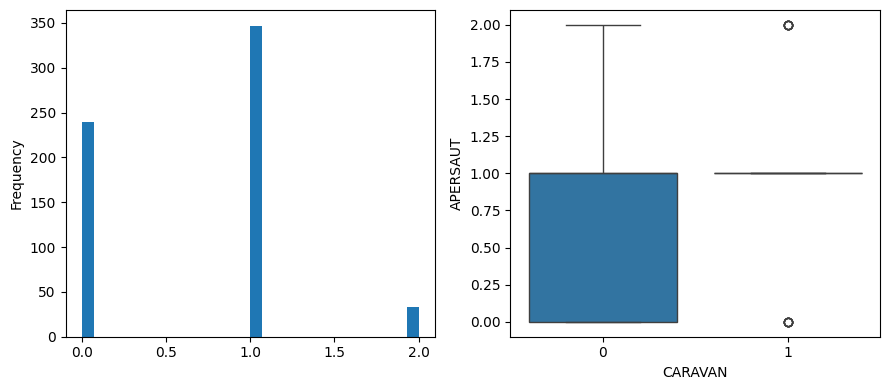

         count  mean  median   std  min  max
CARAVAN                                     
0          575  0.64     1.0  0.57    0    2
1           44  1.00     1.0  0.53    0    2 


=== ABESAUT ===
 ---> Límites Outliers ABESAUT 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
ABESAUT  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          576   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        ABESAUT
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


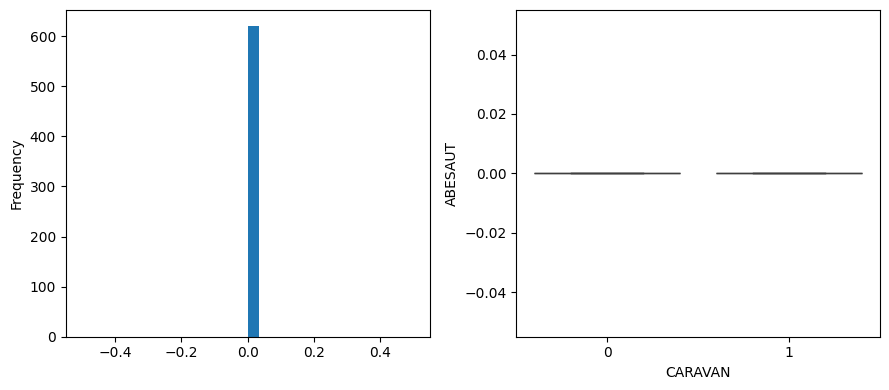

         count  mean  median  std  min  max
CARAVAN                                    
0          576   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== AMOTSCO ===
 ---> Límites Outliers AMOTSCO 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AMOTSCO  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          559   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 

variable        AMOTSCO
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


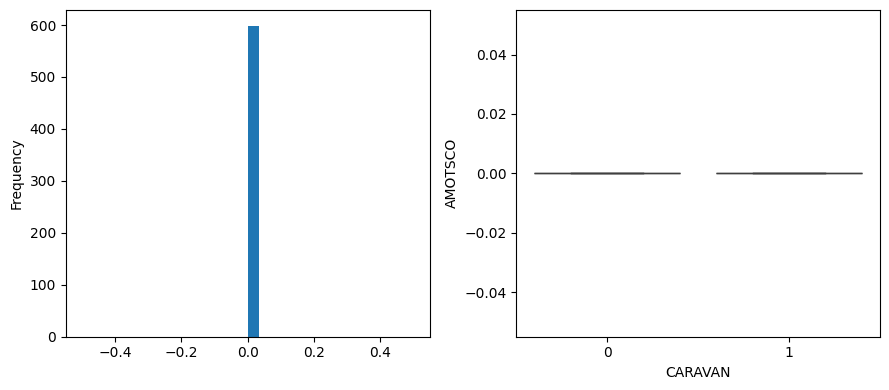

         count  mean  median  std  min  max
CARAVAN                                    
0          559   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 


=== AVRAAUT ===
 ---> Límites Outliers AVRAAUT 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AVRAAUT  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        AVRAAUT
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


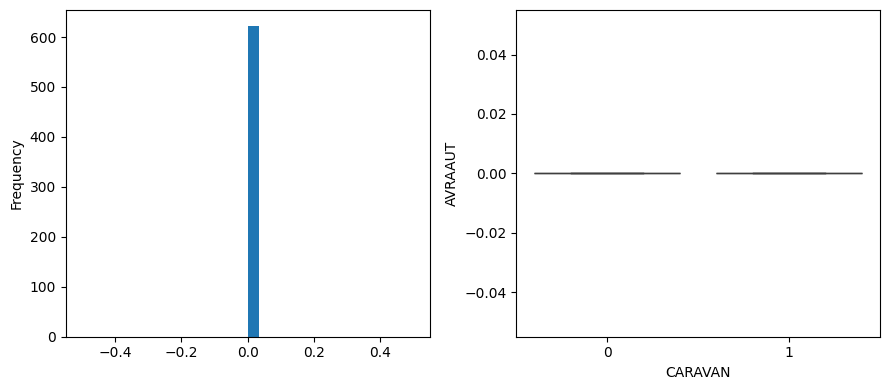

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== AAANHANG ===
 ---> Límites Outliers AAANHANG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AAANHANG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        AAANHANG
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


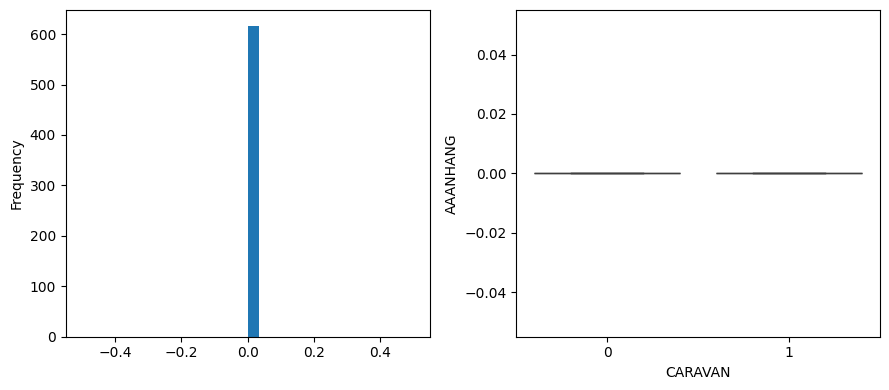

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== ATRACTOR ===
 ---> Límites Outliers ATRACTOR 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
ATRACTOR  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          565   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        ATRACTOR
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


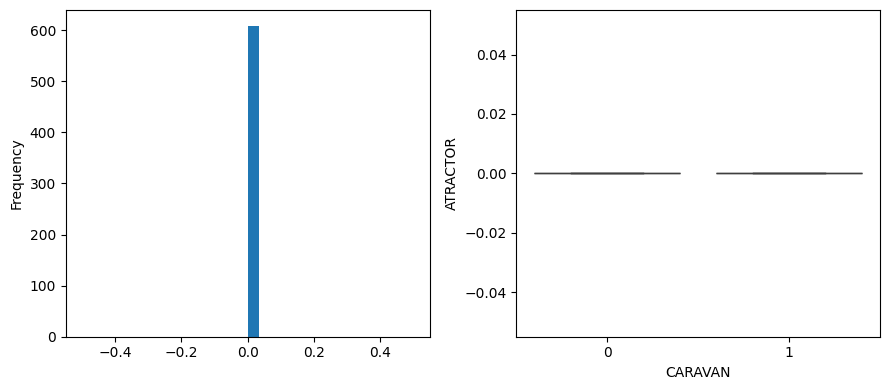

         count  mean  median  std  min  max
CARAVAN                                    
0          565   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== AWERKT ===
 ---> Límites Outliers AWERKT 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AWERKT  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        AWERKT
long_media       False
dif_mean           NaN
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


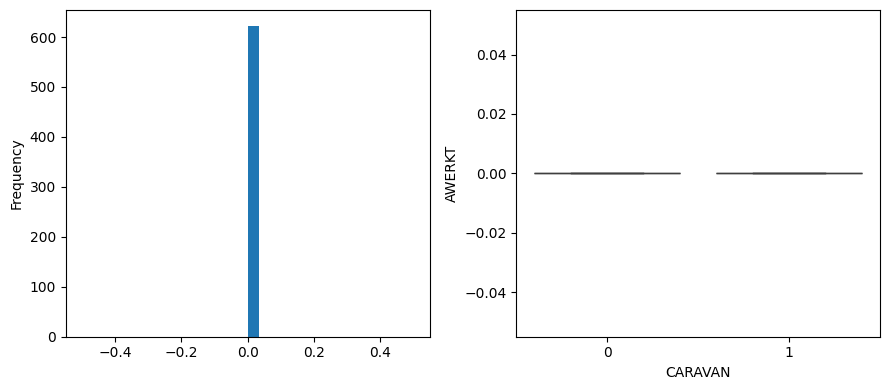

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== ABROM ===
 ---> Límites Outliers ABROM 
         Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
ABROM  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        ABROM
long_media      False
dif_mean          NaN
dif<10%         False
considerar         SI
cambia_rango       SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


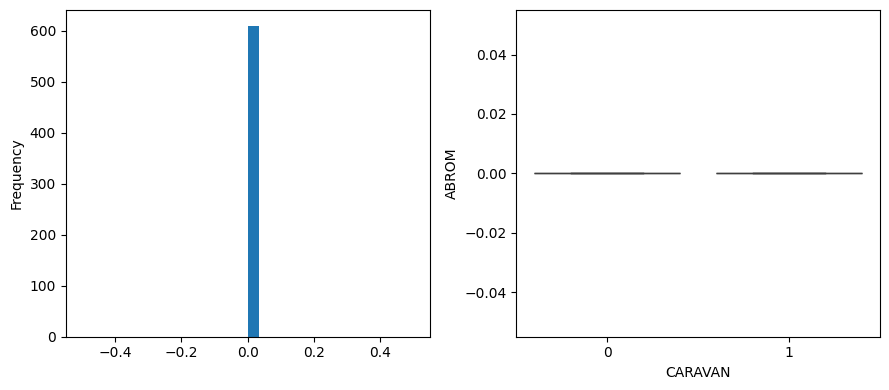

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== ALEVEN ===
 ---> Límites Outliers ALEVEN 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
ALEVEN  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          527   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 

variable        ALEVEN
long_media       False
dif_mean           NaN
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


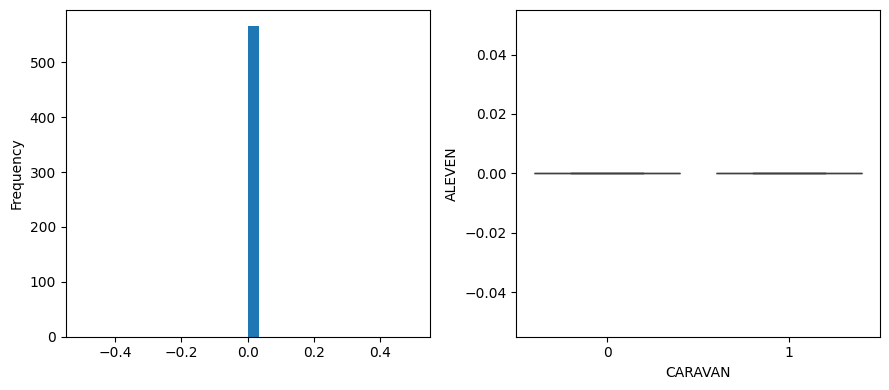

C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


         count  mean  median  std  min  max
CARAVAN                                    
0          527   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 


=== APERSONG ===
 ---> Límites Outliers APERSONG 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
APERSONG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        APERSONG
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



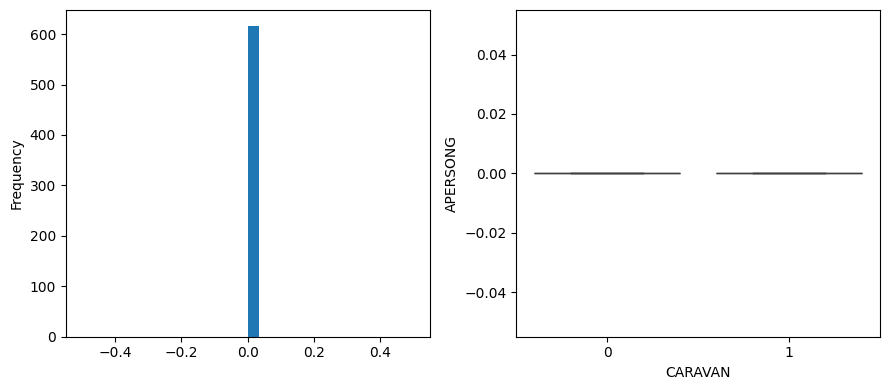

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== AGEZONG ===
 ---> Límites Outliers AGEZONG 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AGEZONG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          574   0.0     0.0  0.0    0    0
1           43   0.0     0.0  0.0    0    0 

variable        AGEZONG
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


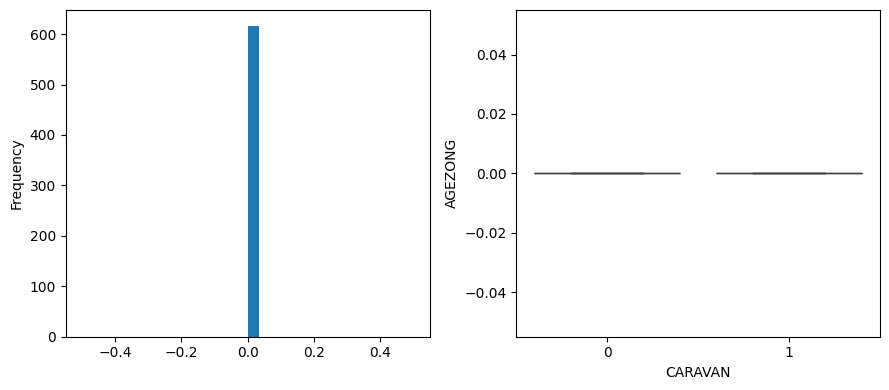

         count  mean  median  std  min  max
CARAVAN                                    
0          574   0.0     0.0  0.0    0    0
1           43   0.0     0.0  0.0    0    0 


=== AWAOREG ===
 ---> Límites Outliers AWAOREG 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AWAOREG  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        AWAOREG
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


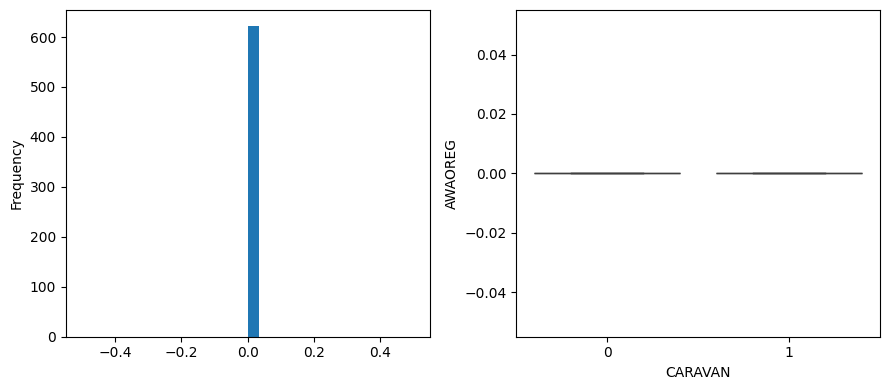

         count  mean  median  std  min  max
CARAVAN                                    
0          578   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== ABRAND ===
 ---> Límites Outliers ABRAND 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
ABRAND  1.0  1.0  0.0    1.0    1.0         0.0       598.0 

         count  mean  median  std  min  max
CARAVAN                                    
0          500   1.0     1.0  0.0    1    1
1           40   1.0     1.0  0.0    1    1 

variable        ABRAND
long_media       False
dif_mean           0.0
dif<10%           True
considerar          NO
cambia_rango        SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


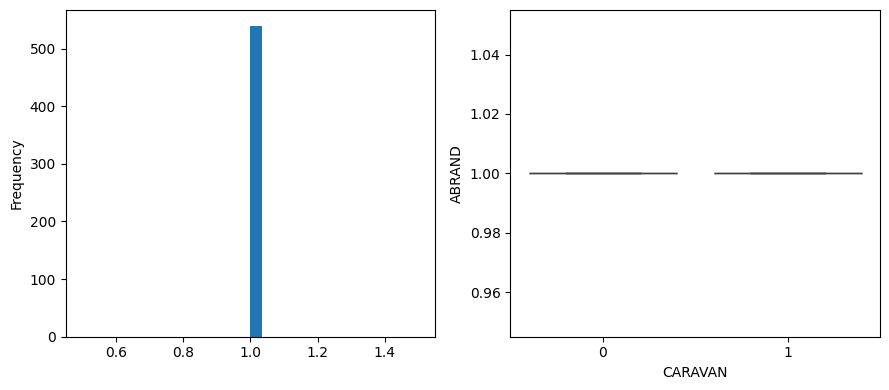

         count  mean  median  std  min  max
CARAVAN                                    
0          500   1.0     1.0  0.0    1    1
1           40   1.0     1.0  0.0    1    1 


=== AZEILPL ===
 ---> Límites Outliers AZEILPL 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AZEILPL  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          577   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        AZEILPL
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


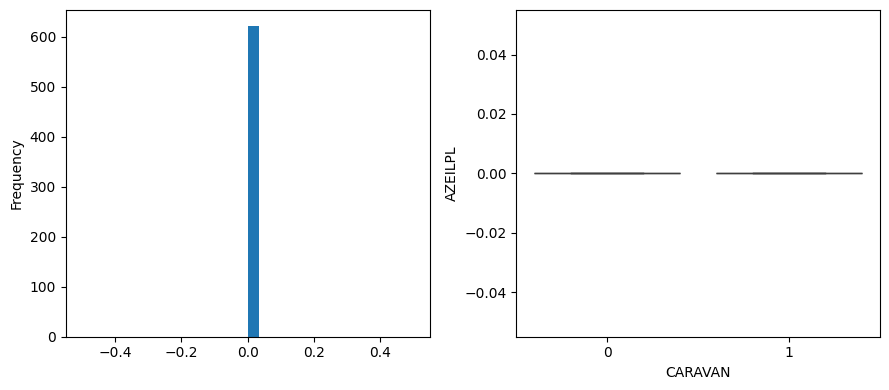

         count  mean  median  std  min  max
CARAVAN                                    
0          577   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== APLEZIER ===
 ---> Límites Outliers APLEZIER 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
APLEZIER  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          577   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 

variable        APLEZIER
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


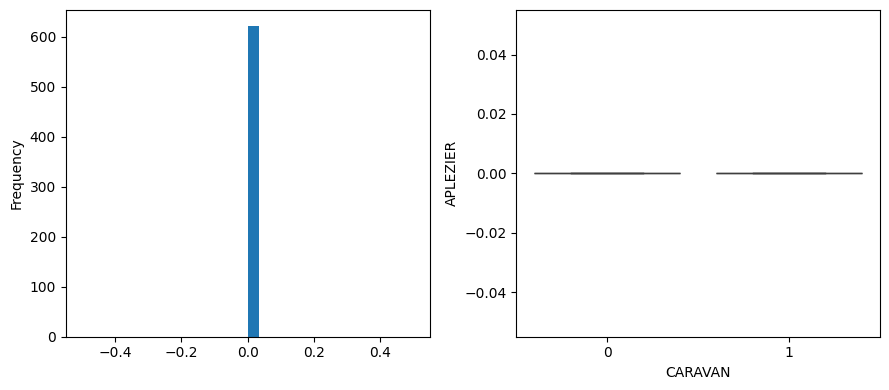

         count  mean  median  std  min  max
CARAVAN                                    
0          577   0.0     0.0  0.0    0    0
1           45   0.0     0.0  0.0    0    0 


=== AFIETS ===
 ---> Límites Outliers AFIETS 
          Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AFIETS  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 

variable        AFIETS
long_media       False
dif_mean           NaN
dif<10%          False
considerar          SI
cambia_rango        SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


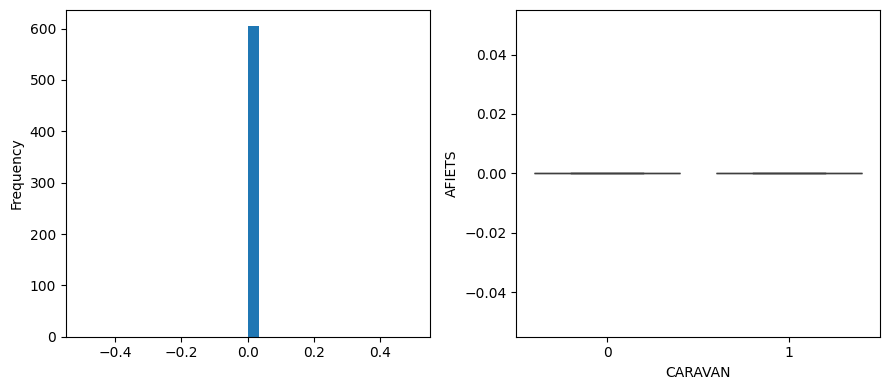

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           40   0.0     0.0  0.0    0    0 


=== AINBOED ===
 ---> Límites Outliers AINBOED 
           Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
AINBOED  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 

variable        AINBOED
long_media        False
dif_mean            NaN
dif<10%           False
considerar           SI
cambia_rango         SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


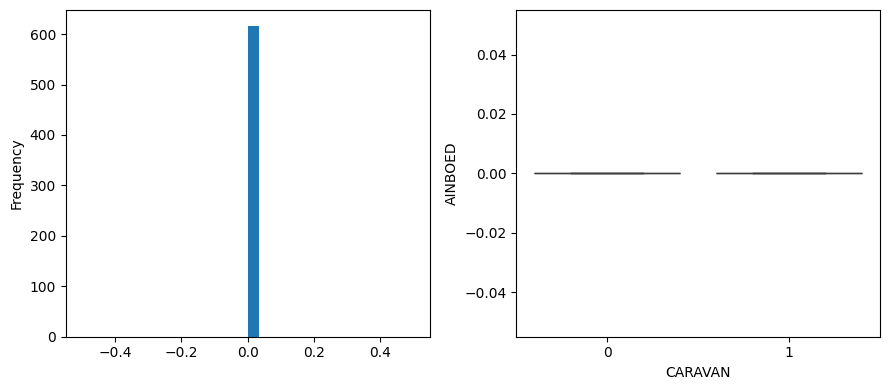

         count  mean  median  std  min  max
CARAVAN                                    
0          573   0.0     0.0  0.0    0    0
1           44   0.0     0.0  0.0    0    0 


=== ABYSTAND ===
 ---> Límites Outliers ABYSTAND 
            Q1   Q3  IQR  lower  upper  extrem_min  extrem_max
ABYSTAND  0.0  0.0  0.0    0.0    0.0         NaN         NaN 

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           42   0.0     0.0  0.0    0    0 

variable        ABYSTAND
long_media         False
dif_mean             NaN
dif<10%            False
considerar            SI
cambia_rango          SI
dtype: object 



C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:24: RuntimeWarning: invalid value encountered in scalar divide
  long_mean = round( abs(tabla_ct.loc[0, 'mean']- tabla_ct.loc[1, 'mean'])/tabla_ct.loc[0, 'mean'],2)
C:\Users\chile\AppData\Local\Temp\ipykernel_23648\2271672741.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dif_media = round( abs(tabla_ct.loc[0, 'max']- tabla_ct.loc[0, 'min'])/abs(tabla_ct.loc[1, 'max']- tabla_ct.loc[1, 'min']),2)


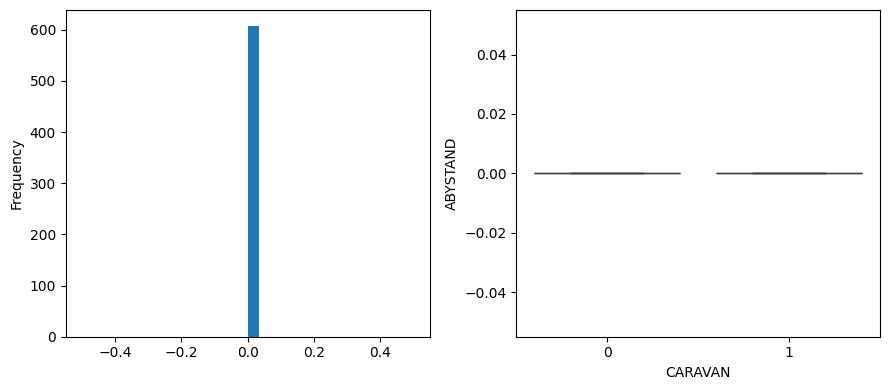

         count  mean  median  std  min  max
CARAVAN                                    
0          566   0.0     0.0  0.0    0    0
1           42   0.0     0.0  0.0    0    0 

           0   1   2
0     MGODPR  NO  NO
1     MGODOV  NO  SI
2     MGODGE  SI  SI
3     MRELGE  NO  SI
4     MRELSA  NO  SI
..       ...  ..  ..
69   AZEILPL  SI  SI
70  APLEZIER  SI  SI
71    AFIETS  SI  SI
72   AINBOED  SI  SI
73  ABYSTAND  SI  SI

[74 rows x 3 columns]


In [749]:
df_depuracion = df_clean.drop(columns=EXCLUDE_COLS, errors="ignore")

resultados = []

for col in df_depuracion.columns:
    if col == "CARAVAN":  # evita usar el target como y_var
        continue
    print(f"\n=== {col} ===")
    tab_compara, para_modelo = info_variable("CARAVAN", col, df_clean, 1, 2)
    print(tab_compara, "\n")
    resultados.append(para_modelo)

df_diagnostico = pd.DataFrame(resultados)
print(df_diagnostico)

   # num_cols = df_clean.select_dtypes(include="number").columns.drop("CARAVAN", errors="ignore")

In [788]:
df_filtrado = df_diagnostico[
    (df_diagnostico.iloc[:, 1] == "NO") | 
    (df_diagnostico.iloc[:, 2] == "NO")]
print(df_filtrado)

var_NO_consider = df_filtrado.iloc[:, 0].tolist()

EXCLUDE_FINAL = v_lista_mantener + ['MBERBOER'] + var_NO_consider

           0   1   2
0     MGODPR  NO  NO
1     MGODOV  NO  SI
3     MRELGE  NO  SI
4     MRELSA  NO  SI
7   MFGEKIND  SI  NO
8   MFWEKIND  NO  SI
9   MOPLHOOG  SI  NO
10  MOPLMIDD  SI  NO
11  MOPLLAAG  SI  NO
13  MBERZELF  SI  NO
14  MBERMIDD  SI  NO
17     MSKB1  NO  NO
18     MSKB2  NO  SI
19      MSKC  NO  NO
21    MHHUUR  SI  NO
22    MHKOOP  SI  NO
23     MAUT1  NO  SI
24     MAUT2  NO  SI
26   MZFONDS  NO  SI
29  MINK3045  NO  SI
30  MINK4575  SI  NO
31  MINK7512  SI  NO
33   MINKGEM  SI  NO
56  APERSAUT  SI  NO
68    ABRAND  NO  SI


In [789]:
df_mod = df_clean.drop(columns=EXCLUDE_FINAL, errors="ignore")
df_mod.head()

,MOSTYPE,MOSHOOFD,MGODGE,MRELOV,MFALLEEN,MBERHOOG,MBERARBG,MBERARBO,MSKD,MAUT0,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,37,8,4,4,4,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
1,9,3,4,2,2,4,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
2,33,8,2,0,0,2,5,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,22,5,4,2,0,0,1,5,0,2,...,0,0,0,0,0,0,0,0,0,0
4,33,8,3,2,0,0,0,3,0,2,...,0,0,0,0,0,827,0,0,0,0


In [790]:
corr = df_mod.corr(numeric_only=True)
umbral = 0.3

# tomar solo triángulo superior para evitar duplicados y excluir la diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_upper = corr.where(mask)

# “desapilar” y filtrar por umbral absoluto
pares_fuertes = (
    corr_upper.stack()
              .rename("r")
              .pipe(lambda s: s[abs(s) >= umbral])
              .sort_values(key=abs, ascending=False)
)

print("Pares de variables con |r| ≥ 0.7:")
print(pares_fuertes)

Pares de variables con |r| ≥ 0.7:
MOSTYPE  MOSHOOFD    0.992055
MAUT0    AWAOREG     0.554323
PWALAND  PINBOED     0.456116
PBESAUT  AGEZONG     0.378537
PWALAND  PFIETS      0.321423
Name: r, dtype: float64


In [ ]:
# Vamos a mantener MOSTTYPE que contiene los subtipos de cliente
# MAUT0, indica quienes no tienen auto
# PINBOED, indica Contribution property insurance policies      
# PBESAUT Contribution delivery van policies , AGEZONG Number of family accidents insurance policies    
# PFIETS Contribution bicycle policies 


In [793]:
# Vamos a generar eliminar varaibles correlacionadas

delete_var = ['MOSHOOFD','AWAOREG','PWALAND','PBESAUT']
EXCLUDE_FINAL = v_lista_mantener + ['MBERBOER'] + var_NO_consider + delete_var
df_mod_p2 = df_mod.drop(columns=EXCLUDE_FINAL, errors="ignore")

In [862]:
print(EXCLUDE_FINAL)

['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MSKA', 'PWAPART', 'AWAPART', 'MBERBOER', 'MGODPR', 'MGODOV', 'MRELGE', 'MRELSA', 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERZELF', 'MBERMIDD', 'MSKB1', 'MSKB2', 'MSKC', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2', 'MZFONDS', 'MINK3045', 'MINK4575', 'MINK7512', 'MINKGEM', 'APERSAUT', 'ABRAND', 'MOSHOOFD', 'AWAOREG', 'PWALAND', 'PBESAUT']


CARAVAN     1.000000
PPERSAUT    0.122094
PWERKT      0.117906
AAANHANG    0.104928
APERSONG    0.102220
Name: CARAVAN, dtype: float64


C:\Users\chile\AppData\Local\Temp\ipykernel_23648\3032331233.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_filtrada.values, y=corr_filtrada.index, palette="coolwarm")


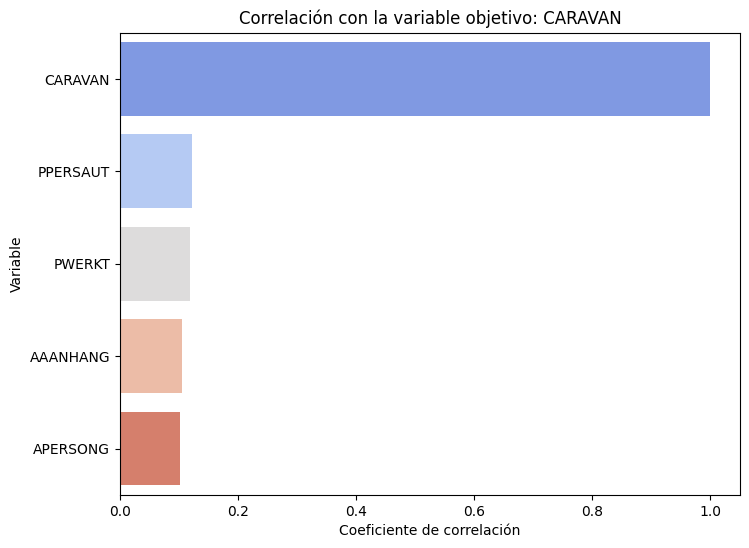

In [798]:
target = "CARAVAN"

corr_target = df_mod_p2.corr(numeric_only=True)[target].sort_values(ascending=False)
corr_filtrada = corr_target[(abs(corr_target) > 0.1)]
print(corr_filtrada)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_filtrada.values, y=corr_filtrada.index, palette="coolwarm")
plt.title(f"Correlación con la variable objetivo: {target}")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variable")
plt.show()

In [809]:
X = df_mod_p2.select_dtypes(include=['number']).dropna()

# Estandarizar (muy importante para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [840]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)  # puedes cambiar el número de componentes
X_pca = pca.fit_transform(X_scaled)

In [841]:
var_explicada = np.round(pca.explained_variance_ratio_ * 100, 2)
print("Varianza explicada por componente:")
print(var_explicada)

Varianza explicada por componente:
[2.83 2.73 2.58 2.57 2.49 2.34 2.29 2.18 2.16 2.11 2.09 2.08 2.07 2.07
 2.06]


In [842]:
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,0.102568,0.779257,-0.151631,-0.089669,0.127753,0.003770,-0.166456,-0.009776,-0.083953,-0.019713,0.045207,-0.041515,-0.016611,-0.019982,0.001366
1,-0.154617,-0.631953,0.179995,0.312839,-0.509785,0.014309,-0.029062,-0.074185,-0.046057,-0.003809,0.001344,0.013629,-0.046201,0.020983,-0.025308
2,0.013951,3.256521,-1.111160,-0.620670,-1.676234,-8.677468,9.299860,0.696220,1.151240,-0.369431,-0.225179,0.152853,0.112873,0.267427,0.350671
3,-0.169047,0.249921,-0.087462,2.147929,1.429383,-0.094007,-0.051115,0.053137,0.164536,0.885145,0.376658,0.600036,-0.516102,-1.938847,0.614651
4,0.278503,2.508289,-0.492340,-0.113047,0.072662,0.219197,-1.445165,-0.048079,-1.284523,2.343584,1.204925,-2.818668,-0.806443,-0.894291,-3.731073


C:\Users\chile\AppData\Local\Temp\ipykernel_23648\386041844.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'PC{i+1}' for i in range(pca.n_components_)], y=var_explicada, palette="viridis")


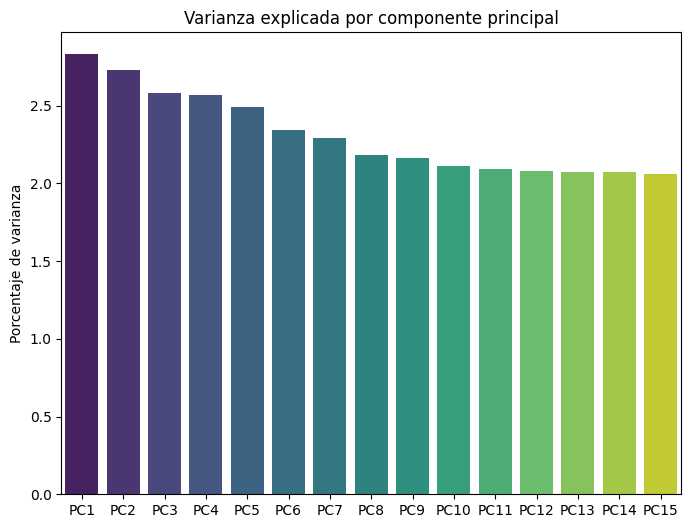

In [843]:
plt.figure(figsize=(8,6))
sns.barplot(x=[f'PC{i+1}' for i in range(pca.n_components_)], y=var_explicada, palette="viridis")
plt.title("Varianza explicada por componente principal")
plt.ylabel("Porcentaje de varianza")
plt.show()

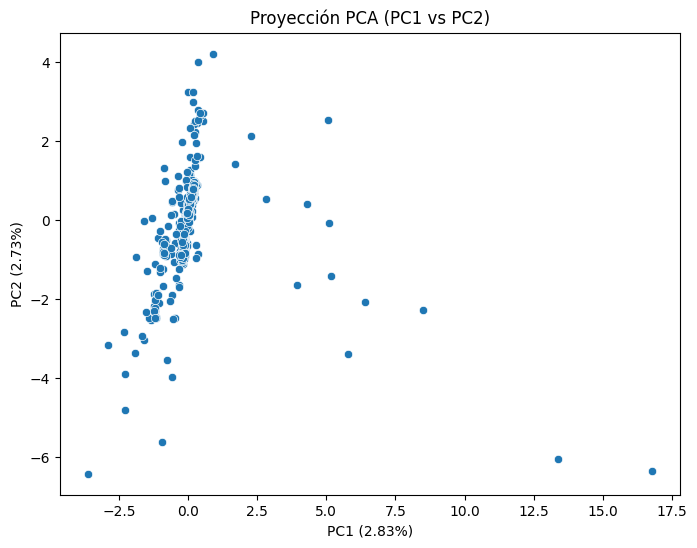

In [844]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'])
plt.title("Proyección PCA (PC1 vs PC2)")
plt.xlabel(f"PC1 ({var_explicada[0]}%)")
plt.ylabel(f"PC2 ({var_explicada[1]}%)")
plt.show()

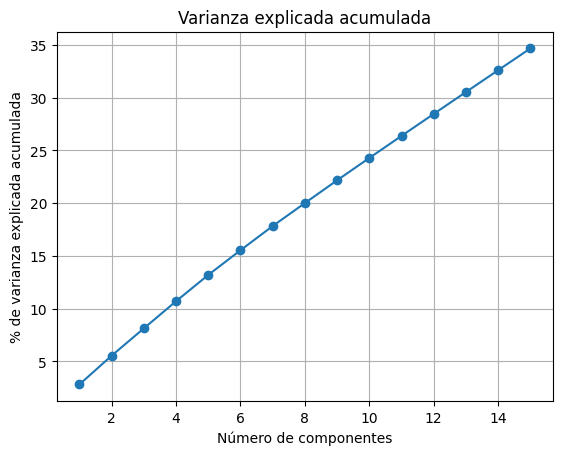

In [845]:
var_acum = np.cumsum(pca.explained_variance_ratio_) * 100
plt.plot(range(1, len(var_acum)+1), var_acum, marker='o')
plt.title("Varianza explicada acumulada")
plt.xlabel("Número de componentes")
plt.ylabel("% de varianza explicada acumulada")
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [854]:
datos_x = df_pca

#X = df_mod_p2.drop('CARAVAN', axis=1)
#y = df_mod_p2['CARAVAN']

X = datos_x
y = df_mod_p2['CARAVAN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [860]:
model = LogisticRegression(max_iter=1000, tol=0.0001)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [856]:
y_pred = model.predict(X_test)

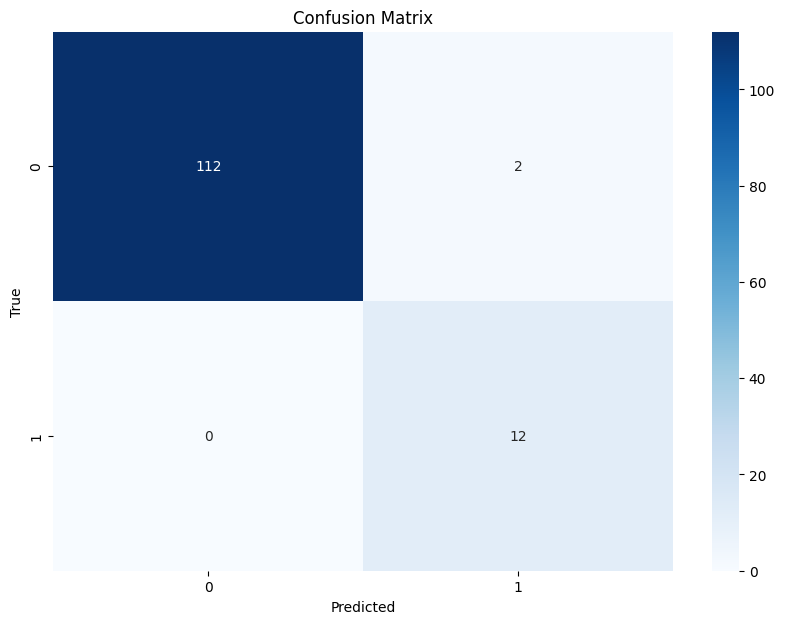

In [857]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [858]:
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()

print(report_df)

              precision    recall  f1-score     support
0              1.000000  0.982456  0.991150  114.000000
1              0.857143  1.000000  0.923077   12.000000
accuracy       0.984127  0.984127  0.984127    0.984127
macro avg      0.928571  0.991228  0.957114  126.000000
weighted avg   0.986395  0.984127  0.984667  126.000000


In [859]:
scores = cross_val_score(model, X, y, cv=5)
print("Average accuracy with CV:", np.mean(scores))

Average accuracy with CV: 0.9792253968253968


In [861]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Entrenamiento:", accuracy_score(y_train, y_pred_train))
print("Prueba:", accuracy_score(y_test, y_pred_test))

Entrenamiento: 0.988
Prueba: 0.9841269841269841
